# Expected SARSA 

In the following notebook, we implement the RL algorithm *Expected-SARSA* using a deep neural network parametrization for the q-function, $Q(s, a)$, together with an $\epsilon$-greedy policy scheme. The Expected-SARSA algorithm is very similar to the Q-Learning algorithm. The only difference is the expectation taken in the update rule over the action space
$$
\begin{align}
	Q_{t+1}(S_t, A_t) &= Q_{t}(S_t, A_t) + \alpha\left[R_{t+1} + \gamma \sum_{a}\pi(a\vert S_{t+1})Q_{t}(S_{t+1}, a) - Q_{t}(S_{t}, A_{t})\right],
\end{align}
$$

The details of the Q-Learning algorithm, which is very similar, are in the figure below, borrowed from the Introduction to RL book by Sutton & Barto [1]. In addition, we deviate from the original Expected-SARSA algorithm only in our usage of a neural network instead of a tabular q-function.

We use the *Acrobot-v1* environment illustrated below, borrowed from the [Acrobot Gymnasium webpage](https://gymnasium.farama.org/environments/classic_control/acrobot/)

<img src="../assets/acrobot.gif"/>

So, let's begin.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym

In [2]:
# define a dictionary for saving results
results_data_dict = {}

Adding a few utility functions for plotting.

In [3]:
def plot_results(avg_scores, std_scores, name=None):
    # set title name
    if name is not None:
        title_name = f"Score averaged over different experiments ({name})"
    else:
        title_name = f"Score averaged over different experiments"
    
    # plot the results from a set of experiments
    n_episodes = len(avg_scores[0])
    n_experiments = len(avg_scores)

    avg_scores = np.array(avg_scores)
    avg_avg_scores = np.mean(avg_scores, axis=0)
    std_avg_scores = np.std(avg_scores, axis=0)

    upper_std_scores = avg_avg_scores + std_avg_scores
    lower_std_scores = avg_avg_scores - std_avg_scores
    x = range(1, n_episodes + 1)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11, 6), sharex=True)
    
    ax[0].set_title(title_name)
    ax[0].plot(x, avg_avg_scores, label=f'average score')
    ax[0].fill_between(x, upper_std_scores, lower_std_scores, 
                    where=(upper_std_scores > lower_std_scores), alpha=0.3)

    for i in range(n_experiments):
        avg_scores_numpy = np.array(avg_scores[i])
        std_scores_numpy = np.array(std_scores[i])
        upper = avg_scores_numpy + std_scores_numpy
        lower = avg_scores_numpy - std_scores_numpy
        ax[1].plot(x, avg_scores_numpy, label=f'Exp-{i}')
        ax[1].fill_between(x, upper, lower, where=(upper > lower), alpha=0.3)

    ax[1].set_xlabel('episode')
    ax[0].set_ylabel('score')
    ax[1].set_ylabel('score')
    ax[0].legend()
    ax[0].grid()
    ax[1].legend()
    ax[1].grid()
    plt.show()

# Q-Learning without a Replay Buffer

Below is the complete Q-Learning algorithm for the tabular case. Recall that we are implementing the Expected-SARSA algorithm, which uses the following update rule (instead of the Q-Learning one),
$$
\begin{align}
	Q_{t+1}(S_t, A_t) &= Q_{t}(S_t, A_t) + \alpha\left[R_{t+1} + \gamma \sum_{a}\pi(a\vert S_{t+1})Q_{t}(S_{t+1}, a) - Q_{t}(S_{t}, A_{t})\right].
\end{align}
$$

We will also use a neural network instead of a tabular Q-function.

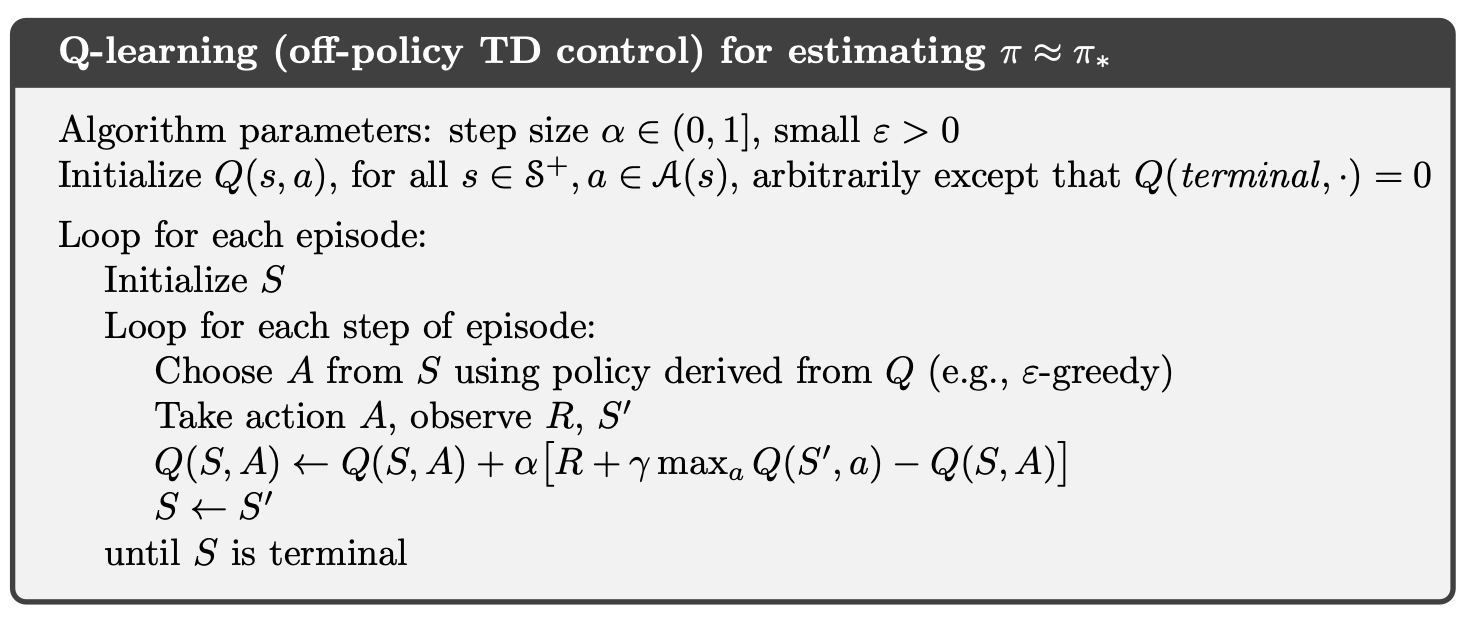

We begin with writing the neural network for the Q-function, which is just a Multi-Layer Perceptron (MLP) with three layers.  

In [4]:
class QNetwork(nn.Module):
    def __init__(self, observation_dim, action_dim, learning_rate):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=observation_dim, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=256)
        self.output_layer = nn.Linear(in_features=256, out_features=action_dim)
    
        self.optimizer = T.optim.Adam(params=self.parameters(), lr=learning_rate)
        self.device = ("cuda:0" if T.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

Then, we write the Expected-SARSA agent class, utilizing an $\epsilon$-greedy policy scheme.

In [23]:
class ExpectedSarsa:
    def __init__(self, observation_dim, action_dim, n_actions, 
                 learning_rate, gamma, epsilon, epsilon_dec, epsilon_min):
        super(ExpectedSarsa, self).__init__()
        self.observation_dim = observation_dim
        self.action_dim = action_dim
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_min
        self.learning_steps = 0
        
        # initialize a q network
        self.q = QNetwork(observation_dim, action_dim, learning_rate)
        
    def choose_action(self, observation, evaluate=False):
        observation = T.from_numpy(observation).float().to(self.q.device)
        if evaluate:
            q_values = self.q(observation)
            action = T.argmax(q_values).item()
        else:
            if np.random.rand() < self.epsilon:
                action = np.random.randint(low=0, high=self.n_actions, size=1)[0]
            else:
                q_values = self.q(observation)
                action = T.argmax(q_values).item()
        return action
                
    
    def decrement_epsilon(self):
        self.epsilon = np.max([self.epsilon - self.epsilon_dec, self.epsilon_min])
    
    def learn(self, observation, action, reward, next_observation, terminated):
        self.learning_steps += 1
        
        # send the transition to the device
        observation = T.from_numpy(observation).float().to(self.q.device)
        reward = T.tensor([reward]).float().to(self.q.device)
        next_observation = T.from_numpy(next_observation).float().to(self.q.device)
        
        # compute the q_values
        q_value = self.q(observation)[action].unsqueeze(dim=0)
        
        # compute the probabilities of next actions using a softmax 
        probs = T.softmax(self.q(next_observation), dim=0)
        
        # compute the next expected q-value
        expected_next_q_value = T.dot(probs, self.q(next_observation)).unsqueeze(dim=0)
        
        if terminated:
            expected_next_q_value = 0. * expected_next_q_value
        target = (reward + self.gamma * expected_next_q_value)
        
        # compute the loss and backpropagate
        self.q.optimizer.zero_grad()
        q_loss = F.mse_loss(q_value, target)
        q_loss.backward()
        self.q.optimizer.step()
        
        # decrement epsilon
        self.decrement_epsilon()
    

Finally, we run a few experiments on the Cart-Pole environment.

In [24]:
env = gym.make('Acrobot-v1')
scores = []
avg_scores = []
std_scores = []
epsilons = []

N_EXPERIMENTS = 5
N_EPISODES = 2000
MAX_STEPS = 600
GAMMA = 0.99
LR = 5e-5
EPSILON = 1.
EPSILON_MIN = 0.001
EPSILON_DEC = (EPSILON - EPSILON_MIN) / (N_EPISODES * 0.1)
OBSERVATION_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.n
N_ACTIONS = env.action_space.n



for ex_i in range(N_EXPERIMENTS):
    scores.append([])
    avg_scores.append([])
    std_scores.append([])
    epsilons.append([])

    agent = ExpectedSarsa(observation_dim=OBSERVATION_DIM, action_dim=ACTION_DIM, n_actions=N_ACTIONS, 
                          learning_rate=LR, gamma=GAMMA, epsilon=EPSILON, epsilon_dec=EPSILON_DEC, 
                          epsilon_min=EPSILON_MIN)
    for ep_i in range(N_EPISODES):
        observation, info = env.reset()
        score = 0
        step = 0
        done = False

        while not done:
            step += 1
            epsilons[ex_i].append(agent.epsilon)
            action = agent.choose_action(observation)
            next_observation, reward, terminated, truncated, info = env.step(action)
            score += reward
            
            # train the agent
            agent.learn(observation, action, reward, next_observation, terminated)
            
            # set next states to current states
            observation = next_observation
            
            # check for termination
            if terminated or truncated or step==MAX_STEPS:
                done = True
                scores[ex_i].append(score)
                avg_scores[ex_i].append(np.mean(scores[ex_i][-100:]))
                std_scores[ex_i].append(np.std(scores[ex_i][-100:]))
            
        print(f'| Experiment: {ex_i + 1:4} | Episode: {ep_i:4} | Score: {np.round(score, 2):2.3f}' + \
              f'| Avg score: {np.round(avg_scores[ex_i][-1], 2):2.3f} |')
env.close()

| Experiment:    1 | Episode:    0 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    1 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    2 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    3 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    4 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    5 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    6 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    7 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    8 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:    9 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:   10 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:   11 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:   12 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    1 | Episode:  108 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  109 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  110 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  111 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  112 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  113 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  114 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  115 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  116 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  117 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  118 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  119 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  120 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    1 | Episode:  216 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  217 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  218 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  219 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  220 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  221 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  222 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  223 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  224 | Score: -500.000| Avg score: -500.000 |
| Experiment:    1 | Episode:  225 | Score: -474.000| Avg score: -499.740 |
| Experiment:    1 | Episode:  226 | Score: -500.000| Avg score: -499.740 |
| Experiment:    1 | Episode:  227 | Score: -500.000| Avg score: -499.740 |
| Experiment:    1 | Episode:  228 | Score: -500.000| Avg score: -499.740 |
| Experiment

| Experiment:    1 | Episode:  324 | Score: -500.000| Avg score: -492.140 |
| Experiment:    1 | Episode:  325 | Score: -500.000| Avg score: -492.400 |
| Experiment:    1 | Episode:  326 | Score: -500.000| Avg score: -492.400 |
| Experiment:    1 | Episode:  327 | Score: -500.000| Avg score: -492.400 |
| Experiment:    1 | Episode:  328 | Score: -500.000| Avg score: -492.400 |
| Experiment:    1 | Episode:  329 | Score: -500.000| Avg score: -492.400 |
| Experiment:    1 | Episode:  330 | Score: -500.000| Avg score: -492.400 |
| Experiment:    1 | Episode:  331 | Score: -500.000| Avg score: -492.400 |
| Experiment:    1 | Episode:  332 | Score: -500.000| Avg score: -492.400 |
| Experiment:    1 | Episode:  333 | Score: -500.000| Avg score: -492.700 |
| Experiment:    1 | Episode:  334 | Score: -220.000| Avg score: -489.900 |
| Experiment:    1 | Episode:  335 | Score: -500.000| Avg score: -489.900 |
| Experiment:    1 | Episode:  336 | Score: -500.000| Avg score: -489.900 |
| Experiment

| Experiment:    1 | Episode:  432 | Score: -482.000| Avg score: -460.550 |
| Experiment:    1 | Episode:  433 | Score: -344.000| Avg score: -458.990 |
| Experiment:    1 | Episode:  434 | Score: -500.000| Avg score: -461.790 |
| Experiment:    1 | Episode:  435 | Score: -500.000| Avg score: -461.790 |
| Experiment:    1 | Episode:  436 | Score: -500.000| Avg score: -461.790 |
| Experiment:    1 | Episode:  437 | Score: -231.000| Avg score: -459.100 |
| Experiment:    1 | Episode:  438 | Score: -500.000| Avg score: -459.100 |
| Experiment:    1 | Episode:  439 | Score: -394.000| Avg score: -458.040 |
| Experiment:    1 | Episode:  440 | Score: -500.000| Avg score: -458.040 |
| Experiment:    1 | Episode:  441 | Score: -452.000| Avg score: -458.700 |
| Experiment:    1 | Episode:  442 | Score: -500.000| Avg score: -458.700 |
| Experiment:    1 | Episode:  443 | Score: -467.000| Avg score: -458.370 |
| Experiment:    1 | Episode:  444 | Score: -500.000| Avg score: -460.050 |
| Experiment

| Experiment:    1 | Episode:  540 | Score: -500.000| Avg score: -429.730 |
| Experiment:    1 | Episode:  541 | Score: -268.000| Avg score: -427.890 |
| Experiment:    1 | Episode:  542 | Score: -178.000| Avg score: -424.670 |
| Experiment:    1 | Episode:  543 | Score: -500.000| Avg score: -425.000 |
| Experiment:    1 | Episode:  544 | Score: -224.000| Avg score: -422.240 |
| Experiment:    1 | Episode:  545 | Score: -500.000| Avg score: -422.240 |
| Experiment:    1 | Episode:  546 | Score: -388.000| Avg score: -423.530 |
| Experiment:    1 | Episode:  547 | Score: -351.000| Avg score: -422.040 |
| Experiment:    1 | Episode:  548 | Score: -500.000| Avg score: -422.040 |
| Experiment:    1 | Episode:  549 | Score: -500.000| Avg score: -423.720 |
| Experiment:    1 | Episode:  550 | Score: -500.000| Avg score: -423.720 |
| Experiment:    1 | Episode:  551 | Score: -279.000| Avg score: -421.510 |
| Experiment:    1 | Episode:  552 | Score: -200.000| Avg score: -418.670 |
| Experiment

| Experiment:    1 | Episode:  648 | Score: -177.000| Avg score: -391.240 |
| Experiment:    1 | Episode:  649 | Score: -199.000| Avg score: -388.230 |
| Experiment:    1 | Episode:  650 | Score: -500.000| Avg score: -388.230 |
| Experiment:    1 | Episode:  651 | Score: -500.000| Avg score: -390.440 |
| Experiment:    1 | Episode:  652 | Score: -487.000| Avg score: -393.310 |
| Experiment:    1 | Episode:  653 | Score: -500.000| Avg score: -393.310 |
| Experiment:    1 | Episode:  654 | Score: -500.000| Avg score: -393.440 |
| Experiment:    1 | Episode:  655 | Score: -500.000| Avg score: -395.520 |
| Experiment:    1 | Episode:  656 | Score: -380.000| Avg score: -394.320 |
| Experiment:    1 | Episode:  657 | Score: -500.000| Avg score: -395.700 |
| Experiment:    1 | Episode:  658 | Score: -165.000| Avg score: -395.040 |
| Experiment:    1 | Episode:  659 | Score: -473.000| Avg score: -394.770 |
| Experiment:    1 | Episode:  660 | Score: -216.000| Avg score: -392.010 |
| Experiment

| Experiment:    1 | Episode:  756 | Score: -500.000| Avg score: -387.420 |
| Experiment:    1 | Episode:  757 | Score: -335.000| Avg score: -385.770 |
| Experiment:    1 | Episode:  758 | Score: -284.000| Avg score: -386.960 |
| Experiment:    1 | Episode:  759 | Score: -500.000| Avg score: -387.230 |
| Experiment:    1 | Episode:  760 | Score: -300.000| Avg score: -388.070 |
| Experiment:    1 | Episode:  761 | Score: -350.000| Avg score: -386.570 |
| Experiment:    1 | Episode:  762 | Score: -422.000| Avg score: -387.410 |
| Experiment:    1 | Episode:  763 | Score: -312.000| Avg score: -385.530 |
| Experiment:    1 | Episode:  764 | Score: -500.000| Avg score: -389.030 |
| Experiment:    1 | Episode:  765 | Score: -376.000| Avg score: -387.790 |
| Experiment:    1 | Episode:  766 | Score: -389.000| Avg score: -389.750 |
| Experiment:    1 | Episode:  767 | Score: -500.000| Avg score: -389.850 |
| Experiment:    1 | Episode:  768 | Score: -500.000| Avg score: -391.210 |
| Experiment

| Experiment:    1 | Episode:  865 | Score: -186.000| Avg score: -374.480 |
| Experiment:    1 | Episode:  866 | Score: -500.000| Avg score: -375.590 |
| Experiment:    1 | Episode:  867 | Score: -465.000| Avg score: -375.240 |
| Experiment:    1 | Episode:  868 | Score: -306.000| Avg score: -373.300 |
| Experiment:    1 | Episode:  869 | Score: -500.000| Avg score: -374.520 |
| Experiment:    1 | Episode:  870 | Score: -500.000| Avg score: -376.220 |
| Experiment:    1 | Episode:  871 | Score: -268.000| Avg score: -374.270 |
| Experiment:    1 | Episode:  872 | Score: -336.000| Avg score: -374.300 |
| Experiment:    1 | Episode:  873 | Score: -336.000| Avg score: -372.660 |
| Experiment:    1 | Episode:  874 | Score: -382.000| Avg score: -373.820 |
| Experiment:    1 | Episode:  875 | Score: -389.000| Avg score: -373.480 |
| Experiment:    1 | Episode:  876 | Score: -181.000| Avg score: -372.910 |
| Experiment:    1 | Episode:  877 | Score: -500.000| Avg score: -372.910 |
| Experiment

| Experiment:    1 | Episode:  973 | Score: -500.000| Avg score: -354.130 |
| Experiment:    1 | Episode:  974 | Score: -470.000| Avg score: -355.010 |
| Experiment:    1 | Episode:  975 | Score: -400.000| Avg score: -355.120 |
| Experiment:    1 | Episode:  976 | Score: -372.000| Avg score: -357.030 |
| Experiment:    1 | Episode:  977 | Score: -266.000| Avg score: -354.690 |
| Experiment:    1 | Episode:  978 | Score: -344.000| Avg score: -355.340 |
| Experiment:    1 | Episode:  979 | Score: -381.000| Avg score: -355.030 |
| Experiment:    1 | Episode:  980 | Score: -433.000| Avg score: -356.610 |
| Experiment:    1 | Episode:  981 | Score: -348.000| Avg score: -355.400 |
| Experiment:    1 | Episode:  982 | Score: -492.000| Avg score: -356.280 |
| Experiment:    1 | Episode:  983 | Score: -413.000| Avg score: -355.410 |
| Experiment:    1 | Episode:  984 | Score: -222.000| Avg score: -356.230 |
| Experiment:    1 | Episode:  985 | Score: -488.000| Avg score: -356.110 |
| Experiment

| Experiment:    1 | Episode: 1081 | Score: -347.000| Avg score: -346.160 |
| Experiment:    1 | Episode: 1082 | Score: -242.000| Avg score: -343.660 |
| Experiment:    1 | Episode: 1083 | Score: -241.000| Avg score: -341.940 |
| Experiment:    1 | Episode: 1084 | Score: -378.000| Avg score: -343.500 |
| Experiment:    1 | Episode: 1085 | Score: -500.000| Avg score: -343.620 |
| Experiment:    1 | Episode: 1086 | Score: -500.000| Avg score: -346.990 |
| Experiment:    1 | Episode: 1087 | Score: -159.000| Avg score: -345.210 |
| Experiment:    1 | Episode: 1088 | Score: -278.000| Avg score: -345.430 |
| Experiment:    1 | Episode: 1089 | Score: -500.000| Avg score: -347.090 |
| Experiment:    1 | Episode: 1090 | Score: -270.000| Avg score: -347.300 |
| Experiment:    1 | Episode: 1091 | Score: -156.000| Avg score: -346.510 |
| Experiment:    1 | Episode: 1092 | Score: -500.000| Avg score: -346.510 |
| Experiment:    1 | Episode: 1093 | Score: -447.000| Avg score: -347.210 |
| Experiment

| Experiment:    1 | Episode: 1190 | Score: -358.000| Avg score: -320.480 |
| Experiment:    1 | Episode: 1191 | Score: -136.000| Avg score: -320.280 |
| Experiment:    1 | Episode: 1192 | Score: -205.000| Avg score: -317.330 |
| Experiment:    1 | Episode: 1193 | Score: -500.000| Avg score: -317.860 |
| Experiment:    1 | Episode: 1194 | Score: -500.000| Avg score: -320.100 |
| Experiment:    1 | Episode: 1195 | Score: -237.000| Avg score: -319.360 |
| Experiment:    1 | Episode: 1196 | Score: -160.000| Avg score: -316.660 |
| Experiment:    1 | Episode: 1197 | Score: -326.000| Avg score: -317.650 |
| Experiment:    1 | Episode: 1198 | Score: -399.000| Avg score: -318.760 |
| Experiment:    1 | Episode: 1199 | Score: -476.000| Avg score: -318.520 |
| Experiment:    1 | Episode: 1200 | Score: -152.000| Avg score: -315.900 |
| Experiment:    1 | Episode: 1201 | Score: -316.000| Avg score: -317.240 |
| Experiment:    1 | Episode: 1202 | Score: -305.000| Avg score: -317.480 |
| Experiment

| Experiment:    1 | Episode: 1298 | Score: -245.000| Avg score: -305.660 |
| Experiment:    1 | Episode: 1299 | Score: -500.000| Avg score: -305.900 |
| Experiment:    1 | Episode: 1300 | Score: -380.000| Avg score: -308.180 |
| Experiment:    1 | Episode: 1301 | Score: -220.000| Avg score: -307.220 |
| Experiment:    1 | Episode: 1302 | Score: -230.000| Avg score: -306.470 |
| Experiment:    1 | Episode: 1303 | Score: -237.000| Avg score: -303.840 |
| Experiment:    1 | Episode: 1304 | Score: -298.000| Avg score: -303.810 |
| Experiment:    1 | Episode: 1305 | Score: -377.000| Avg score: -302.850 |
| Experiment:    1 | Episode: 1306 | Score: -151.000| Avg score: -301.520 |
| Experiment:    1 | Episode: 1307 | Score: -379.000| Avg score: -301.590 |
| Experiment:    1 | Episode: 1308 | Score: -352.000| Avg score: -302.890 |
| Experiment:    1 | Episode: 1309 | Score: -241.000| Avg score: -303.380 |
| Experiment:    1 | Episode: 1310 | Score: -245.000| Avg score: -302.820 |
| Experiment

| Experiment:    1 | Episode: 1406 | Score: -214.000| Avg score: -277.340 |
| Experiment:    1 | Episode: 1407 | Score: -243.000| Avg score: -275.980 |
| Experiment:    1 | Episode: 1408 | Score: -307.000| Avg score: -275.530 |
| Experiment:    1 | Episode: 1409 | Score: -175.000| Avg score: -274.870 |
| Experiment:    1 | Episode: 1410 | Score: -162.000| Avg score: -274.040 |
| Experiment:    1 | Episode: 1411 | Score: -500.000| Avg score: -275.540 |
| Experiment:    1 | Episode: 1412 | Score: -426.000| Avg score: -277.170 |
| Experiment:    1 | Episode: 1413 | Score: -236.000| Avg score: -277.710 |
| Experiment:    1 | Episode: 1414 | Score: -195.000| Avg score: -277.580 |
| Experiment:    1 | Episode: 1415 | Score: -486.000| Avg score: -279.650 |
| Experiment:    1 | Episode: 1416 | Score: -231.000| Avg score: -276.960 |
| Experiment:    1 | Episode: 1417 | Score: -424.000| Avg score: -278.340 |
| Experiment:    1 | Episode: 1418 | Score: -306.000| Avg score: -278.840 |
| Experiment

| Experiment:    1 | Episode: 1514 | Score: -239.000| Avg score: -282.450 |
| Experiment:    1 | Episode: 1515 | Score: -294.000| Avg score: -280.530 |
| Experiment:    1 | Episode: 1516 | Score: -244.000| Avg score: -280.660 |
| Experiment:    1 | Episode: 1517 | Score: -276.000| Avg score: -279.180 |
| Experiment:    1 | Episode: 1518 | Score: -231.000| Avg score: -278.430 |
| Experiment:    1 | Episode: 1519 | Score: -348.000| Avg score: -280.660 |
| Experiment:    1 | Episode: 1520 | Score: -274.000| Avg score: -279.250 |
| Experiment:    1 | Episode: 1521 | Score: -103.000| Avg score: -277.240 |
| Experiment:    1 | Episode: 1522 | Score: -331.000| Avg score: -277.900 |
| Experiment:    1 | Episode: 1523 | Score: -330.000| Avg score: -276.200 |
| Experiment:    1 | Episode: 1524 | Score: -189.000| Avg score: -273.090 |
| Experiment:    1 | Episode: 1525 | Score: -243.000| Avg score: -272.610 |
| Experiment:    1 | Episode: 1526 | Score: -331.000| Avg score: -271.360 |
| Experiment

| Experiment:    1 | Episode: 1622 | Score: -209.000| Avg score: -260.280 |
| Experiment:    1 | Episode: 1623 | Score: -215.000| Avg score: -259.130 |
| Experiment:    1 | Episode: 1624 | Score: -171.000| Avg score: -258.950 |
| Experiment:    1 | Episode: 1625 | Score: -358.000| Avg score: -260.100 |
| Experiment:    1 | Episode: 1626 | Score: -122.000| Avg score: -258.010 |
| Experiment:    1 | Episode: 1627 | Score: -260.000| Avg score: -258.290 |
| Experiment:    1 | Episode: 1628 | Score: -399.000| Avg score: -260.110 |
| Experiment:    1 | Episode: 1629 | Score: -322.000| Avg score: -261.490 |
| Experiment:    1 | Episode: 1630 | Score: -174.000| Avg score: -260.650 |
| Experiment:    1 | Episode: 1631 | Score: -247.000| Avg score: -258.440 |
| Experiment:    1 | Episode: 1632 | Score: -199.000| Avg score: -255.900 |
| Experiment:    1 | Episode: 1633 | Score: -172.000| Avg score: -256.080 |
| Experiment:    1 | Episode: 1634 | Score: -177.000| Avg score: -256.350 |
| Experiment

| Experiment:    1 | Episode: 1730 | Score: -195.000| Avg score: -239.920 |
| Experiment:    1 | Episode: 1731 | Score: -246.000| Avg score: -239.910 |
| Experiment:    1 | Episode: 1732 | Score: -478.000| Avg score: -242.700 |
| Experiment:    1 | Episode: 1733 | Score: -281.000| Avg score: -243.790 |
| Experiment:    1 | Episode: 1734 | Score: -384.000| Avg score: -245.860 |
| Experiment:    1 | Episode: 1735 | Score: -253.000| Avg score: -244.680 |
| Experiment:    1 | Episode: 1736 | Score: -203.000| Avg score: -243.990 |
| Experiment:    1 | Episode: 1737 | Score: -176.000| Avg score: -244.620 |
| Experiment:    1 | Episode: 1738 | Score: -308.000| Avg score: -242.910 |
| Experiment:    1 | Episode: 1739 | Score: -200.000| Avg score: -243.530 |
| Experiment:    1 | Episode: 1740 | Score: -358.000| Avg score: -245.210 |
| Experiment:    1 | Episode: 1741 | Score: -102.000| Avg score: -244.190 |
| Experiment:    1 | Episode: 1742 | Score: -135.000| Avg score: -243.160 |
| Experiment

| Experiment:    1 | Episode: 1839 | Score: -124.000| Avg score: -232.850 |
| Experiment:    1 | Episode: 1840 | Score: -117.000| Avg score: -230.440 |
| Experiment:    1 | Episode: 1841 | Score: -208.000| Avg score: -231.500 |
| Experiment:    1 | Episode: 1842 | Score: -123.000| Avg score: -231.380 |
| Experiment:    1 | Episode: 1843 | Score: -274.000| Avg score: -232.540 |
| Experiment:    1 | Episode: 1844 | Score: -387.000| Avg score: -234.840 |
| Experiment:    1 | Episode: 1845 | Score: -298.000| Avg score: -235.670 |
| Experiment:    1 | Episode: 1846 | Score: -247.000| Avg score: -234.440 |
| Experiment:    1 | Episode: 1847 | Score: -156.000| Avg score: -234.500 |
| Experiment:    1 | Episode: 1848 | Score: -179.000| Avg score: -234.080 |
| Experiment:    1 | Episode: 1849 | Score: -267.000| Avg score: -232.340 |
| Experiment:    1 | Episode: 1850 | Score: -203.000| Avg score: -231.920 |
| Experiment:    1 | Episode: 1851 | Score: -136.000| Avg score: -229.340 |
| Experiment

| Experiment:    1 | Episode: 1947 | Score: -303.000| Avg score: -223.990 |
| Experiment:    1 | Episode: 1948 | Score: -186.000| Avg score: -224.060 |
| Experiment:    1 | Episode: 1949 | Score: -97.000| Avg score: -222.360 |
| Experiment:    1 | Episode: 1950 | Score: -208.000| Avg score: -222.410 |
| Experiment:    1 | Episode: 1951 | Score: -168.000| Avg score: -222.730 |
| Experiment:    1 | Episode: 1952 | Score: -206.000| Avg score: -223.200 |
| Experiment:    1 | Episode: 1953 | Score: -135.000| Avg score: -223.300 |
| Experiment:    1 | Episode: 1954 | Score: -105.000| Avg score: -221.110 |
| Experiment:    1 | Episode: 1955 | Score: -155.000| Avg score: -220.490 |
| Experiment:    1 | Episode: 1956 | Score: -127.000| Avg score: -218.910 |
| Experiment:    1 | Episode: 1957 | Score: -329.000| Avg score: -220.300 |
| Experiment:    1 | Episode: 1958 | Score: -142.000| Avg score: -219.360 |
| Experiment:    1 | Episode: 1959 | Score: -122.000| Avg score: -219.030 |
| Experiment:

| Experiment:    2 | Episode:   55 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   56 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   57 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   58 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   59 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   60 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   61 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   62 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   63 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   64 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   65 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   66 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:   67 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    2 | Episode:  163 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  164 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  165 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  166 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  167 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  168 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  169 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  170 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  171 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  172 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  173 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  174 | Score: -500.000| Avg score: -500.000 |
| Experiment:    2 | Episode:  175 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    2 | Episode:  271 | Score: -500.000| Avg score: -498.690 |
| Experiment:    2 | Episode:  272 | Score: -500.000| Avg score: -498.690 |
| Experiment:    2 | Episode:  273 | Score: -500.000| Avg score: -498.690 |
| Experiment:    2 | Episode:  274 | Score: -500.000| Avg score: -498.690 |
| Experiment:    2 | Episode:  275 | Score: -500.000| Avg score: -498.690 |
| Experiment:    2 | Episode:  276 | Score: -500.000| Avg score: -498.690 |
| Experiment:    2 | Episode:  277 | Score: -500.000| Avg score: -498.690 |
| Experiment:    2 | Episode:  278 | Score: -500.000| Avg score: -498.690 |
| Experiment:    2 | Episode:  279 | Score: -500.000| Avg score: -498.690 |
| Experiment:    2 | Episode:  280 | Score: -500.000| Avg score: -498.690 |
| Experiment:    2 | Episode:  281 | Score: -500.000| Avg score: -498.690 |
| Experiment:    2 | Episode:  282 | Score: -500.000| Avg score: -498.690 |
| Experiment:    2 | Episode:  283 | Score: -500.000| Avg score: -498.690 |
| Experiment

| Experiment:    2 | Episode:  379 | Score: -500.000| Avg score: -473.020 |
| Experiment:    2 | Episode:  380 | Score: -460.000| Avg score: -472.620 |
| Experiment:    2 | Episode:  381 | Score: -500.000| Avg score: -472.620 |
| Experiment:    2 | Episode:  382 | Score: -186.000| Avg score: -469.480 |
| Experiment:    2 | Episode:  383 | Score: -500.000| Avg score: -469.480 |
| Experiment:    2 | Episode:  384 | Score: -500.000| Avg score: -469.480 |
| Experiment:    2 | Episode:  385 | Score: -500.000| Avg score: -469.480 |
| Experiment:    2 | Episode:  386 | Score: -500.000| Avg score: -469.480 |
| Experiment:    2 | Episode:  387 | Score: -316.000| Avg score: -467.640 |
| Experiment:    2 | Episode:  388 | Score: -500.000| Avg score: -467.640 |
| Experiment:    2 | Episode:  389 | Score: -500.000| Avg score: -467.640 |
| Experiment:    2 | Episode:  390 | Score: -485.000| Avg score: -468.930 |
| Experiment:    2 | Episode:  391 | Score: -500.000| Avg score: -468.930 |
| Experiment

| Experiment:    2 | Episode:  487 | Score: -500.000| Avg score: -434.440 |
| Experiment:    2 | Episode:  488 | Score: -500.000| Avg score: -434.440 |
| Experiment:    2 | Episode:  489 | Score: -500.000| Avg score: -434.440 |
| Experiment:    2 | Episode:  490 | Score: -496.000| Avg score: -434.550 |
| Experiment:    2 | Episode:  491 | Score: -348.000| Avg score: -433.030 |
| Experiment:    2 | Episode:  492 | Score: -500.000| Avg score: -433.030 |
| Experiment:    2 | Episode:  493 | Score: -500.000| Avg score: -433.030 |
| Experiment:    2 | Episode:  494 | Score: -374.000| Avg score: -431.770 |
| Experiment:    2 | Episode:  495 | Score: -343.000| Avg score: -430.470 |
| Experiment:    2 | Episode:  496 | Score: -500.000| Avg score: -430.470 |
| Experiment:    2 | Episode:  497 | Score: -500.000| Avg score: -430.470 |
| Experiment:    2 | Episode:  498 | Score: -232.000| Avg score: -429.730 |
| Experiment:    2 | Episode:  499 | Score: -452.000| Avg score: -430.010 |
| Experiment

| Experiment:    2 | Episode:  595 | Score: -478.000| Avg score: -412.540 |
| Experiment:    2 | Episode:  596 | Score: -446.000| Avg score: -412.000 |
| Experiment:    2 | Episode:  597 | Score: -500.000| Avg score: -412.000 |
| Experiment:    2 | Episode:  598 | Score: -366.000| Avg score: -413.340 |
| Experiment:    2 | Episode:  599 | Score: -500.000| Avg score: -413.820 |
| Experiment:    2 | Episode:  600 | Score: -500.000| Avg score: -413.850 |
| Experiment:    2 | Episode:  601 | Score: -303.000| Avg score: -413.910 |
| Experiment:    2 | Episode:  602 | Score: -387.000| Avg score: -413.590 |
| Experiment:    2 | Episode:  603 | Score: -477.000| Avg score: -415.180 |
| Experiment:    2 | Episode:  604 | Score: -500.000| Avg score: -415.180 |
| Experiment:    2 | Episode:  605 | Score: -99.000| Avg score: -411.170 |
| Experiment:    2 | Episode:  606 | Score: -500.000| Avg score: -411.770 |
| Experiment:    2 | Episode:  607 | Score: -500.000| Avg score: -414.600 |
| Experiment:

| Experiment:    2 | Episode:  703 | Score: -341.000| Avg score: -402.690 |
| Experiment:    2 | Episode:  704 | Score: -213.000| Avg score: -399.820 |
| Experiment:    2 | Episode:  705 | Score: -357.000| Avg score: -402.400 |
| Experiment:    2 | Episode:  706 | Score: -500.000| Avg score: -402.400 |
| Experiment:    2 | Episode:  707 | Score: -500.000| Avg score: -402.400 |
| Experiment:    2 | Episode:  708 | Score: -144.000| Avg score: -400.040 |
| Experiment:    2 | Episode:  709 | Score: -500.000| Avg score: -401.410 |
| Experiment:    2 | Episode:  710 | Score: -246.000| Avg score: -398.870 |
| Experiment:    2 | Episode:  711 | Score: -322.000| Avg score: -398.250 |
| Experiment:    2 | Episode:  712 | Score: -500.000| Avg score: -398.730 |
| Experiment:    2 | Episode:  713 | Score: -440.000| Avg score: -398.750 |
| Experiment:    2 | Episode:  714 | Score: -500.000| Avg score: -399.480 |
| Experiment:    2 | Episode:  715 | Score: -241.000| Avg score: -396.890 |
| Experiment

| Experiment:    2 | Episode:  811 | Score: -449.000| Avg score: -392.350 |
| Experiment:    2 | Episode:  812 | Score: -282.000| Avg score: -390.170 |
| Experiment:    2 | Episode:  813 | Score: -500.000| Avg score: -390.770 |
| Experiment:    2 | Episode:  814 | Score: -346.000| Avg score: -389.230 |
| Experiment:    2 | Episode:  815 | Score: -214.000| Avg score: -388.960 |
| Experiment:    2 | Episode:  816 | Score: -442.000| Avg score: -391.800 |
| Experiment:    2 | Episode:  817 | Score: -500.000| Avg score: -393.520 |
| Experiment:    2 | Episode:  818 | Score: -463.000| Avg score: -393.150 |
| Experiment:    2 | Episode:  819 | Score: -113.000| Avg score: -389.280 |
| Experiment:    2 | Episode:  820 | Score: -469.000| Avg score: -390.150 |
| Experiment:    2 | Episode:  821 | Score: -297.000| Avg score: -390.540 |
| Experiment:    2 | Episode:  822 | Score: -384.000| Avg score: -389.380 |
| Experiment:    2 | Episode:  823 | Score: -425.000| Avg score: -388.630 |
| Experiment

| Experiment:    2 | Episode:  919 | Score: -496.000| Avg score: -381.660 |
| Experiment:    2 | Episode:  920 | Score: -500.000| Avg score: -381.970 |
| Experiment:    2 | Episode:  921 | Score: -384.000| Avg score: -382.840 |
| Experiment:    2 | Episode:  922 | Score: -500.000| Avg score: -384.000 |
| Experiment:    2 | Episode:  923 | Score: -224.000| Avg score: -381.990 |
| Experiment:    2 | Episode:  924 | Score: -318.000| Avg score: -380.200 |
| Experiment:    2 | Episode:  925 | Score: -334.000| Avg score: -378.540 |
| Experiment:    2 | Episode:  926 | Score: -500.000| Avg score: -381.480 |
| Experiment:    2 | Episode:  927 | Score: -277.000| Avg score: -379.290 |
| Experiment:    2 | Episode:  928 | Score: -248.000| Avg score: -377.960 |
| Experiment:    2 | Episode:  929 | Score: -500.000| Avg score: -377.960 |
| Experiment:    2 | Episode:  930 | Score: -280.000| Avg score: -377.040 |
| Experiment:    2 | Episode:  931 | Score: -363.000| Avg score: -375.740 |
| Experiment

| Experiment:    2 | Episode: 1027 | Score: -310.000| Avg score: -341.660 |
| Experiment:    2 | Episode: 1028 | Score: -319.000| Avg score: -342.370 |
| Experiment:    2 | Episode: 1029 | Score: -158.000| Avg score: -338.950 |
| Experiment:    2 | Episode: 1030 | Score: -500.000| Avg score: -341.150 |
| Experiment:    2 | Episode: 1031 | Score: -500.000| Avg score: -342.520 |
| Experiment:    2 | Episode: 1032 | Score: -187.000| Avg score: -339.390 |
| Experiment:    2 | Episode: 1033 | Score: -445.000| Avg score: -339.930 |
| Experiment:    2 | Episode: 1034 | Score: -347.000| Avg score: -339.950 |
| Experiment:    2 | Episode: 1035 | Score: -283.000| Avg score: -339.030 |
| Experiment:    2 | Episode: 1036 | Score: -189.000| Avg score: -339.580 |
| Experiment:    2 | Episode: 1037 | Score: -500.000| Avg score: -341.220 |
| Experiment:    2 | Episode: 1038 | Score: -408.000| Avg score: -342.480 |
| Experiment:    2 | Episode: 1039 | Score: -247.000| Avg score: -341.760 |
| Experiment

| Experiment:    2 | Episode: 1136 | Score: -218.000| Avg score: -311.890 |
| Experiment:    2 | Episode: 1137 | Score: -285.000| Avg score: -309.740 |
| Experiment:    2 | Episode: 1138 | Score: -500.000| Avg score: -310.660 |
| Experiment:    2 | Episode: 1139 | Score: -386.000| Avg score: -312.050 |
| Experiment:    2 | Episode: 1140 | Score: -289.000| Avg score: -310.340 |
| Experiment:    2 | Episode: 1141 | Score: -288.000| Avg score: -310.870 |
| Experiment:    2 | Episode: 1142 | Score: -162.000| Avg score: -309.210 |
| Experiment:    2 | Episode: 1143 | Score: -372.000| Avg score: -311.440 |
| Experiment:    2 | Episode: 1144 | Score: -197.000| Avg score: -308.410 |
| Experiment:    2 | Episode: 1145 | Score: -346.000| Avg score: -308.560 |
| Experiment:    2 | Episode: 1146 | Score: -256.000| Avg score: -309.970 |
| Experiment:    2 | Episode: 1147 | Score: -292.000| Avg score: -311.200 |
| Experiment:    2 | Episode: 1148 | Score: -190.000| Avg score: -308.500 |
| Experiment

| Experiment:    2 | Episode: 1244 | Score: -323.000| Avg score: -285.440 |
| Experiment:    2 | Episode: 1245 | Score: -346.000| Avg score: -285.440 |
| Experiment:    2 | Episode: 1246 | Score: -140.000| Avg score: -284.280 |
| Experiment:    2 | Episode: 1247 | Score: -253.000| Avg score: -283.890 |
| Experiment:    2 | Episode: 1248 | Score: -357.000| Avg score: -285.560 |
| Experiment:    2 | Episode: 1249 | Score: -116.000| Avg score: -281.720 |
| Experiment:    2 | Episode: 1250 | Score: -272.000| Avg score: -280.430 |
| Experiment:    2 | Episode: 1251 | Score: -274.000| Avg score: -282.250 |
| Experiment:    2 | Episode: 1252 | Score: -291.000| Avg score: -282.460 |
| Experiment:    2 | Episode: 1253 | Score: -181.000| Avg score: -282.670 |
| Experiment:    2 | Episode: 1254 | Score: -245.000| Avg score: -280.120 |
| Experiment:    2 | Episode: 1255 | Score: -340.000| Avg score: -279.280 |
| Experiment:    2 | Episode: 1256 | Score: -279.000| Avg score: -278.940 |
| Experiment

| Experiment:    2 | Episode: 1352 | Score: -184.000| Avg score: -276.750 |
| Experiment:    2 | Episode: 1353 | Score: -458.000| Avg score: -279.520 |
| Experiment:    2 | Episode: 1354 | Score: -164.000| Avg score: -278.710 |
| Experiment:    2 | Episode: 1355 | Score: -271.000| Avg score: -278.020 |
| Experiment:    2 | Episode: 1356 | Score: -227.000| Avg score: -277.500 |
| Experiment:    2 | Episode: 1357 | Score: -419.000| Avg score: -279.080 |
| Experiment:    2 | Episode: 1358 | Score: -158.000| Avg score: -277.540 |
| Experiment:    2 | Episode: 1359 | Score: -139.000| Avg score: -276.880 |
| Experiment:    2 | Episode: 1360 | Score: -265.000| Avg score: -277.270 |
| Experiment:    2 | Episode: 1361 | Score: -367.000| Avg score: -277.500 |
| Experiment:    2 | Episode: 1362 | Score: -319.000| Avg score: -277.670 |
| Experiment:    2 | Episode: 1363 | Score: -443.000| Avg score: -279.260 |
| Experiment:    2 | Episode: 1364 | Score: -458.000| Avg score: -279.940 |
| Experiment

| Experiment:    2 | Episode: 1460 | Score: -241.000| Avg score: -270.020 |
| Experiment:    2 | Episode: 1461 | Score: -271.000| Avg score: -269.060 |
| Experiment:    2 | Episode: 1462 | Score: -388.000| Avg score: -269.750 |
| Experiment:    2 | Episode: 1463 | Score: -160.000| Avg score: -266.920 |
| Experiment:    2 | Episode: 1464 | Score: -226.000| Avg score: -264.600 |
| Experiment:    2 | Episode: 1465 | Score: -227.000| Avg score: -264.790 |
| Experiment:    2 | Episode: 1466 | Score: -500.000| Avg score: -267.820 |
| Experiment:    2 | Episode: 1467 | Score: -318.000| Avg score: -269.500 |
| Experiment:    2 | Episode: 1468 | Score: -289.000| Avg score: -270.110 |
| Experiment:    2 | Episode: 1469 | Score: -360.000| Avg score: -270.110 |
| Experiment:    2 | Episode: 1470 | Score: -274.000| Avg score: -271.560 |
| Experiment:    2 | Episode: 1471 | Score: -250.000| Avg score: -271.900 |
| Experiment:    2 | Episode: 1472 | Score: -220.000| Avg score: -270.770 |
| Experiment

| Experiment:    2 | Episode: 1568 | Score: -194.000| Avg score: -241.760 |
| Experiment:    2 | Episode: 1569 | Score: -234.000| Avg score: -240.500 |
| Experiment:    2 | Episode: 1570 | Score: -346.000| Avg score: -241.220 |
| Experiment:    2 | Episode: 1571 | Score: -172.000| Avg score: -240.440 |
| Experiment:    2 | Episode: 1572 | Score: -222.000| Avg score: -240.460 |
| Experiment:    2 | Episode: 1573 | Score: -127.000| Avg score: -238.990 |
| Experiment:    2 | Episode: 1574 | Score: -418.000| Avg score: -240.970 |
| Experiment:    2 | Episode: 1575 | Score: -258.000| Avg score: -241.880 |
| Experiment:    2 | Episode: 1576 | Score: -160.000| Avg score: -241.660 |
| Experiment:    2 | Episode: 1577 | Score: -197.000| Avg score: -241.100 |
| Experiment:    2 | Episode: 1578 | Score: -280.000| Avg score: -242.050 |
| Experiment:    2 | Episode: 1579 | Score: -167.000| Avg score: -240.220 |
| Experiment:    2 | Episode: 1580 | Score: -343.000| Avg score: -241.590 |
| Experiment

| Experiment:    2 | Episode: 1676 | Score: -234.000| Avg score: -239.080 |
| Experiment:    2 | Episode: 1677 | Score: -269.000| Avg score: -239.800 |
| Experiment:    2 | Episode: 1678 | Score: -177.000| Avg score: -238.770 |
| Experiment:    2 | Episode: 1679 | Score: -282.000| Avg score: -239.920 |
| Experiment:    2 | Episode: 1680 | Score: -258.000| Avg score: -239.070 |
| Experiment:    2 | Episode: 1681 | Score: -132.000| Avg score: -237.870 |
| Experiment:    2 | Episode: 1682 | Score: -208.000| Avg score: -237.760 |
| Experiment:    2 | Episode: 1683 | Score: -178.000| Avg score: -236.370 |
| Experiment:    2 | Episode: 1684 | Score: -357.000| Avg score: -238.440 |
| Experiment:    2 | Episode: 1685 | Score: -500.000| Avg score: -241.880 |
| Experiment:    2 | Episode: 1686 | Score: -154.000| Avg score: -241.040 |
| Experiment:    2 | Episode: 1687 | Score: -458.000| Avg score: -244.140 |
| Experiment:    2 | Episode: 1688 | Score: -99.000| Avg score: -242.400 |
| Experiment:

| Experiment:    2 | Episode: 1784 | Score: -239.000| Avg score: -230.580 |
| Experiment:    2 | Episode: 1785 | Score: -168.000| Avg score: -227.260 |
| Experiment:    2 | Episode: 1786 | Score: -213.000| Avg score: -227.850 |
| Experiment:    2 | Episode: 1787 | Score: -328.000| Avg score: -226.550 |
| Experiment:    2 | Episode: 1788 | Score: -155.000| Avg score: -227.110 |
| Experiment:    2 | Episode: 1789 | Score: -229.000| Avg score: -227.130 |
| Experiment:    2 | Episode: 1790 | Score: -252.000| Avg score: -228.460 |
| Experiment:    2 | Episode: 1791 | Score: -193.000| Avg score: -228.740 |
| Experiment:    2 | Episode: 1792 | Score: -171.000| Avg score: -229.060 |
| Experiment:    2 | Episode: 1793 | Score: -246.000| Avg score: -229.220 |
| Experiment:    2 | Episode: 1794 | Score: -349.000| Avg score: -230.870 |
| Experiment:    2 | Episode: 1795 | Score: -220.000| Avg score: -229.570 |
| Experiment:    2 | Episode: 1796 | Score: -245.000| Avg score: -229.720 |
| Experiment

| Experiment:    2 | Episode: 1892 | Score: -150.000| Avg score: -218.530 |
| Experiment:    2 | Episode: 1893 | Score: -147.000| Avg score: -217.540 |
| Experiment:    2 | Episode: 1894 | Score: -369.000| Avg score: -217.740 |
| Experiment:    2 | Episode: 1895 | Score: -375.000| Avg score: -219.290 |
| Experiment:    2 | Episode: 1896 | Score: -327.000| Avg score: -220.110 |
| Experiment:    2 | Episode: 1897 | Score: -112.000| Avg score: -219.560 |
| Experiment:    2 | Episode: 1898 | Score: -143.000| Avg score: -218.800 |
| Experiment:    2 | Episode: 1899 | Score: -93.000| Avg score: -217.030 |
| Experiment:    2 | Episode: 1900 | Score: -196.000| Avg score: -217.330 |
| Experiment:    2 | Episode: 1901 | Score: -199.000| Avg score: -217.580 |
| Experiment:    2 | Episode: 1902 | Score: -343.000| Avg score: -218.210 |
| Experiment:    2 | Episode: 1903 | Score: -214.000| Avg score: -218.300 |
| Experiment:    2 | Episode: 1904 | Score: -120.000| Avg score: -218.190 |
| Experiment:

| Experiment:    3 | Episode:    0 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:    1 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:    2 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:    3 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:    4 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:    5 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:    6 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:    7 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:    8 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:    9 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   10 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   11 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:   12 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    3 | Episode:  108 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:  109 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:  110 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:  111 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:  112 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:  113 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:  114 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:  115 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:  116 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:  117 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:  118 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:  119 | Score: -500.000| Avg score: -500.000 |
| Experiment:    3 | Episode:  120 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    3 | Episode:  216 | Score: -500.000| Avg score: -499.300 |
| Experiment:    3 | Episode:  217 | Score: -500.000| Avg score: -499.300 |
| Experiment:    3 | Episode:  218 | Score: -500.000| Avg score: -499.300 |
| Experiment:    3 | Episode:  219 | Score: -500.000| Avg score: -499.300 |
| Experiment:    3 | Episode:  220 | Score: -500.000| Avg score: -499.300 |
| Experiment:    3 | Episode:  221 | Score: -500.000| Avg score: -499.300 |
| Experiment:    3 | Episode:  222 | Score: -385.000| Avg score: -498.150 |
| Experiment:    3 | Episode:  223 | Score: -500.000| Avg score: -498.150 |
| Experiment:    3 | Episode:  224 | Score: -500.000| Avg score: -498.150 |
| Experiment:    3 | Episode:  225 | Score: -500.000| Avg score: -498.150 |
| Experiment:    3 | Episode:  226 | Score: -469.000| Avg score: -497.840 |
| Experiment:    3 | Episode:  227 | Score: -500.000| Avg score: -497.840 |
| Experiment:    3 | Episode:  228 | Score: -500.000| Avg score: -497.840 |
| Experiment

| Experiment:    3 | Episode:  324 | Score: -356.000| Avg score: -484.150 |
| Experiment:    3 | Episode:  325 | Score: -500.000| Avg score: -484.150 |
| Experiment:    3 | Episode:  326 | Score: -489.000| Avg score: -484.350 |
| Experiment:    3 | Episode:  327 | Score: -500.000| Avg score: -484.350 |
| Experiment:    3 | Episode:  328 | Score: -500.000| Avg score: -484.350 |
| Experiment:    3 | Episode:  329 | Score: -500.000| Avg score: -484.350 |
| Experiment:    3 | Episode:  330 | Score: -500.000| Avg score: -484.350 |
| Experiment:    3 | Episode:  331 | Score: -500.000| Avg score: -484.350 |
| Experiment:    3 | Episode:  332 | Score: -500.000| Avg score: -484.350 |
| Experiment:    3 | Episode:  333 | Score: -500.000| Avg score: -484.350 |
| Experiment:    3 | Episode:  334 | Score: -500.000| Avg score: -484.350 |
| Experiment:    3 | Episode:  335 | Score: -500.000| Avg score: -484.350 |
| Experiment:    3 | Episode:  336 | Score: -500.000| Avg score: -484.350 |
| Experiment

| Experiment:    3 | Episode:  433 | Score: -500.000| Avg score: -437.800 |
| Experiment:    3 | Episode:  434 | Score: -500.000| Avg score: -437.800 |
| Experiment:    3 | Episode:  435 | Score: -500.000| Avg score: -437.800 |
| Experiment:    3 | Episode:  436 | Score: -500.000| Avg score: -437.800 |
| Experiment:    3 | Episode:  437 | Score: -462.000| Avg score: -437.420 |
| Experiment:    3 | Episode:  438 | Score: -369.000| Avg score: -436.110 |
| Experiment:    3 | Episode:  439 | Score: -500.000| Avg score: -436.110 |
| Experiment:    3 | Episode:  440 | Score: -489.000| Avg score: -436.000 |
| Experiment:    3 | Episode:  441 | Score: -500.000| Avg score: -438.310 |
| Experiment:    3 | Episode:  442 | Score: -332.000| Avg score: -436.630 |
| Experiment:    3 | Episode:  443 | Score: -500.000| Avg score: -436.630 |
| Experiment:    3 | Episode:  444 | Score: -500.000| Avg score: -436.630 |
| Experiment:    3 | Episode:  445 | Score: -376.000| Avg score: -435.390 |
| Experiment

| Experiment:    3 | Episode:  541 | Score: -500.000| Avg score: -419.040 |
| Experiment:    3 | Episode:  542 | Score: -493.000| Avg score: -420.650 |
| Experiment:    3 | Episode:  543 | Score: -271.000| Avg score: -418.360 |
| Experiment:    3 | Episode:  544 | Score: -500.000| Avg score: -418.360 |
| Experiment:    3 | Episode:  545 | Score: -214.000| Avg score: -416.740 |
| Experiment:    3 | Episode:  546 | Score: -289.000| Avg score: -414.630 |
| Experiment:    3 | Episode:  547 | Score: -500.000| Avg score: -414.630 |
| Experiment:    3 | Episode:  548 | Score: -442.000| Avg score: -416.320 |
| Experiment:    3 | Episode:  549 | Score: -500.000| Avg score: -416.320 |
| Experiment:    3 | Episode:  550 | Score: -500.000| Avg score: -416.320 |
| Experiment:    3 | Episode:  551 | Score: -385.000| Avg score: -417.090 |
| Experiment:    3 | Episode:  552 | Score: -405.000| Avg score: -416.530 |
| Experiment:    3 | Episode:  553 | Score: -500.000| Avg score: -418.940 |
| Experiment

| Experiment:    3 | Episode:  649 | Score: -450.000| Avg score: -402.330 |
| Experiment:    3 | Episode:  650 | Score: -398.000| Avg score: -401.310 |
| Experiment:    3 | Episode:  651 | Score: -500.000| Avg score: -402.460 |
| Experiment:    3 | Episode:  652 | Score: -500.000| Avg score: -403.410 |
| Experiment:    3 | Episode:  653 | Score: -224.000| Avg score: -400.650 |
| Experiment:    3 | Episode:  654 | Score: -500.000| Avg score: -402.990 |
| Experiment:    3 | Episode:  655 | Score: -128.000| Avg score: -401.290 |
| Experiment:    3 | Episode:  656 | Score: -500.000| Avg score: -401.290 |
| Experiment:    3 | Episode:  657 | Score: -500.000| Avg score: -403.710 |
| Experiment:    3 | Episode:  658 | Score: -424.000| Avg score: -403.600 |
| Experiment:    3 | Episode:  659 | Score: -468.000| Avg score: -406.040 |
| Experiment:    3 | Episode:  660 | Score: -282.000| Avg score: -403.860 |
| Experiment:    3 | Episode:  661 | Score: -344.000| Avg score: -402.300 |
| Experiment

| Experiment:    3 | Episode:  757 | Score: -470.000| Avg score: -364.770 |
| Experiment:    3 | Episode:  758 | Score: -279.000| Avg score: -363.320 |
| Experiment:    3 | Episode:  759 | Score: -500.000| Avg score: -363.640 |
| Experiment:    3 | Episode:  760 | Score: -500.000| Avg score: -365.820 |
| Experiment:    3 | Episode:  761 | Score: -143.000| Avg score: -363.810 |
| Experiment:    3 | Episode:  762 | Score: -457.000| Avg score: -363.380 |
| Experiment:    3 | Episode:  763 | Score: -500.000| Avg score: -366.170 |
| Experiment:    3 | Episode:  764 | Score: -226.000| Avg score: -364.800 |
| Experiment:    3 | Episode:  765 | Score: -500.000| Avg score: -367.660 |
| Experiment:    3 | Episode:  766 | Score: -500.000| Avg score: -367.660 |
| Experiment:    3 | Episode:  767 | Score: -327.000| Avg score: -366.020 |
| Experiment:    3 | Episode:  768 | Score: -368.000| Avg score: -367.230 |
| Experiment:    3 | Episode:  769 | Score: -500.000| Avg score: -367.810 |
| Experiment

| Experiment:    3 | Episode:  865 | Score: -338.000| Avg score: -368.660 |
| Experiment:    3 | Episode:  866 | Score: -500.000| Avg score: -368.660 |
| Experiment:    3 | Episode:  867 | Score: -473.000| Avg score: -370.120 |
| Experiment:    3 | Episode:  868 | Score: -260.000| Avg score: -369.040 |
| Experiment:    3 | Episode:  869 | Score: -318.000| Avg score: -367.220 |
| Experiment:    3 | Episode:  870 | Score: -158.000| Avg score: -367.220 |
| Experiment:    3 | Episode:  871 | Score: -380.000| Avg score: -366.020 |
| Experiment:    3 | Episode:  872 | Score: -436.000| Avg score: -368.310 |
| Experiment:    3 | Episode:  873 | Score: -500.000| Avg score: -368.940 |
| Experiment:    3 | Episode:  874 | Score: -353.000| Avg score: -369.150 |
| Experiment:    3 | Episode:  875 | Score: -113.000| Avg score: -365.280 |
| Experiment:    3 | Episode:  876 | Score: -500.000| Avg score: -367.770 |
| Experiment:    3 | Episode:  877 | Score: -290.000| Avg score: -366.100 |
| Experiment

| Experiment:    3 | Episode:  974 | Score: -284.000| Avg score: -335.610 |
| Experiment:    3 | Episode:  975 | Score: -460.000| Avg score: -339.080 |
| Experiment:    3 | Episode:  976 | Score: -339.000| Avg score: -337.470 |
| Experiment:    3 | Episode:  977 | Score: -236.000| Avg score: -336.930 |
| Experiment:    3 | Episode:  978 | Score: -377.000| Avg score: -337.770 |
| Experiment:    3 | Episode:  979 | Score: -500.000| Avg score: -340.000 |
| Experiment:    3 | Episode:  980 | Score: -308.000| Avg score: -339.320 |
| Experiment:    3 | Episode:  981 | Score: -219.000| Avg score: -338.790 |
| Experiment:    3 | Episode:  982 | Score: -415.000| Avg score: -338.780 |
| Experiment:    3 | Episode:  983 | Score: -262.000| Avg score: -337.500 |
| Experiment:    3 | Episode:  984 | Score: -278.000| Avg score: -338.070 |
| Experiment:    3 | Episode:  985 | Score: -355.000| Avg score: -338.650 |
| Experiment:    3 | Episode:  986 | Score: -493.000| Avg score: -340.110 |
| Experiment

| Experiment:    3 | Episode: 1082 | Score: -402.000| Avg score: -319.330 |
| Experiment:    3 | Episode: 1083 | Score: -472.000| Avg score: -321.430 |
| Experiment:    3 | Episode: 1084 | Score: -147.000| Avg score: -320.120 |
| Experiment:    3 | Episode: 1085 | Score: -500.000| Avg score: -321.570 |
| Experiment:    3 | Episode: 1086 | Score: -360.000| Avg score: -320.240 |
| Experiment:    3 | Episode: 1087 | Score: -174.000| Avg score: -320.750 |
| Experiment:    3 | Episode: 1088 | Score: -495.000| Avg score: -322.240 |
| Experiment:    3 | Episode: 1089 | Score: -191.000| Avg score: -320.410 |
| Experiment:    3 | Episode: 1090 | Score: -500.000| Avg score: -322.650 |
| Experiment:    3 | Episode: 1091 | Score: -228.000| Avg score: -320.350 |
| Experiment:    3 | Episode: 1092 | Score: -438.000| Avg score: -321.980 |
| Experiment:    3 | Episode: 1093 | Score: -370.000| Avg score: -322.960 |
| Experiment:    3 | Episode: 1094 | Score: -271.000| Avg score: -321.830 |
| Experiment

| Experiment:    3 | Episode: 1190 | Score: -478.000| Avg score: -325.120 |
| Experiment:    3 | Episode: 1191 | Score: -151.000| Avg score: -324.350 |
| Experiment:    3 | Episode: 1192 | Score: -298.000| Avg score: -322.950 |
| Experiment:    3 | Episode: 1193 | Score: -122.000| Avg score: -320.470 |
| Experiment:    3 | Episode: 1194 | Score: -396.000| Avg score: -321.720 |
| Experiment:    3 | Episode: 1195 | Score: -349.000| Avg score: -321.940 |
| Experiment:    3 | Episode: 1196 | Score: -144.000| Avg score: -321.050 |
| Experiment:    3 | Episode: 1197 | Score: -216.000| Avg score: -318.890 |
| Experiment:    3 | Episode: 1198 | Score: -298.000| Avg score: -319.270 |
| Experiment:    3 | Episode: 1199 | Score: -230.000| Avg score: -318.830 |
| Experiment:    3 | Episode: 1200 | Score: -500.000| Avg score: -321.350 |
| Experiment:    3 | Episode: 1201 | Score: -323.000| Avg score: -319.580 |
| Experiment:    3 | Episode: 1202 | Score: -205.000| Avg score: -319.980 |
| Experiment

| Experiment:    3 | Episode: 1298 | Score: -465.000| Avg score: -288.120 |
| Experiment:    3 | Episode: 1299 | Score: -210.000| Avg score: -287.920 |
| Experiment:    3 | Episode: 1300 | Score: -443.000| Avg score: -287.350 |
| Experiment:    3 | Episode: 1301 | Score: -290.000| Avg score: -287.020 |
| Experiment:    3 | Episode: 1302 | Score: -182.000| Avg score: -286.790 |
| Experiment:    3 | Episode: 1303 | Score: -358.000| Avg score: -286.540 |
| Experiment:    3 | Episode: 1304 | Score: -194.000| Avg score: -285.380 |
| Experiment:    3 | Episode: 1305 | Score: -441.000| Avg score: -285.580 |
| Experiment:    3 | Episode: 1306 | Score: -265.000| Avg score: -285.970 |
| Experiment:    3 | Episode: 1307 | Score: -244.000| Avg score: -285.720 |
| Experiment:    3 | Episode: 1308 | Score: -192.000| Avg score: -284.560 |
| Experiment:    3 | Episode: 1309 | Score: -130.000| Avg score: -281.530 |
| Experiment:    3 | Episode: 1310 | Score: -363.000| Avg score: -283.480 |
| Experiment

| Experiment:    3 | Episode: 1406 | Score: -275.000| Avg score: -277.460 |
| Experiment:    3 | Episode: 1407 | Score: -252.000| Avg score: -277.540 |
| Experiment:    3 | Episode: 1408 | Score: -259.000| Avg score: -278.210 |
| Experiment:    3 | Episode: 1409 | Score: -354.000| Avg score: -280.450 |
| Experiment:    3 | Episode: 1410 | Score: -170.000| Avg score: -278.520 |
| Experiment:    3 | Episode: 1411 | Score: -454.000| Avg score: -281.610 |
| Experiment:    3 | Episode: 1412 | Score: -194.000| Avg score: -278.550 |
| Experiment:    3 | Episode: 1413 | Score: -202.000| Avg score: -276.780 |
| Experiment:    3 | Episode: 1414 | Score: -259.000| Avg score: -276.740 |
| Experiment:    3 | Episode: 1415 | Score: -324.000| Avg score: -276.050 |
| Experiment:    3 | Episode: 1416 | Score: -253.000| Avg score: -274.560 |
| Experiment:    3 | Episode: 1417 | Score: -330.000| Avg score: -274.870 |
| Experiment:    3 | Episode: 1418 | Score: -233.000| Avg score: -274.270 |
| Experiment

| Experiment:    3 | Episode: 1515 | Score: -438.000| Avg score: -263.010 |
| Experiment:    3 | Episode: 1516 | Score: -122.000| Avg score: -261.700 |
| Experiment:    3 | Episode: 1517 | Score: -328.000| Avg score: -261.680 |
| Experiment:    3 | Episode: 1518 | Score: -306.000| Avg score: -262.410 |
| Experiment:    3 | Episode: 1519 | Score: -122.000| Avg score: -262.570 |
| Experiment:    3 | Episode: 1520 | Score: -233.000| Avg score: -262.720 |
| Experiment:    3 | Episode: 1521 | Score: -469.000| Avg score: -262.990 |
| Experiment:    3 | Episode: 1522 | Score: -273.000| Avg score: -262.220 |
| Experiment:    3 | Episode: 1523 | Score: -167.000| Avg score: -260.450 |
| Experiment:    3 | Episode: 1524 | Score: -251.000| Avg score: -261.180 |
| Experiment:    3 | Episode: 1525 | Score: -92.000| Avg score: -260.210 |
| Experiment:    3 | Episode: 1526 | Score: -331.000| Avg score: -261.630 |
| Experiment:    3 | Episode: 1527 | Score: -307.000| Avg score: -262.610 |
| Experiment:

| Experiment:    3 | Episode: 1624 | Score: -189.000| Avg score: -251.940 |
| Experiment:    3 | Episode: 1625 | Score: -156.000| Avg score: -252.580 |
| Experiment:    3 | Episode: 1626 | Score: -151.000| Avg score: -250.780 |
| Experiment:    3 | Episode: 1627 | Score: -290.000| Avg score: -250.610 |
| Experiment:    3 | Episode: 1628 | Score: -194.000| Avg score: -250.230 |
| Experiment:    3 | Episode: 1629 | Score: -254.000| Avg score: -250.110 |
| Experiment:    3 | Episode: 1630 | Score: -260.000| Avg score: -251.060 |
| Experiment:    3 | Episode: 1631 | Score: -141.000| Avg score: -249.250 |
| Experiment:    3 | Episode: 1632 | Score: -282.000| Avg score: -250.940 |
| Experiment:    3 | Episode: 1633 | Score: -276.000| Avg score: -250.410 |
| Experiment:    3 | Episode: 1634 | Score: -375.000| Avg score: -252.860 |
| Experiment:    3 | Episode: 1635 | Score: -173.000| Avg score: -249.970 |
| Experiment:    3 | Episode: 1636 | Score: -330.000| Avg score: -252.090 |
| Experiment

| Experiment:    3 | Episode: 1733 | Score: -357.000| Avg score: -243.130 |
| Experiment:    3 | Episode: 1734 | Score: -138.000| Avg score: -240.760 |
| Experiment:    3 | Episode: 1735 | Score: -108.000| Avg score: -240.110 |
| Experiment:    3 | Episode: 1736 | Score: -208.000| Avg score: -238.890 |
| Experiment:    3 | Episode: 1737 | Score: -198.000| Avg score: -238.210 |
| Experiment:    3 | Episode: 1738 | Score: -133.000| Avg score: -235.920 |
| Experiment:    3 | Episode: 1739 | Score: -162.000| Avg score: -235.120 |
| Experiment:    3 | Episode: 1740 | Score: -297.000| Avg score: -235.350 |
| Experiment:    3 | Episode: 1741 | Score: -321.000| Avg score: -236.590 |
| Experiment:    3 | Episode: 1742 | Score: -130.000| Avg score: -235.350 |
| Experiment:    3 | Episode: 1743 | Score: -165.000| Avg score: -234.940 |
| Experiment:    3 | Episode: 1744 | Score: -354.000| Avg score: -236.250 |
| Experiment:    3 | Episode: 1745 | Score: -317.000| Avg score: -237.200 |
| Experiment

| Experiment:    3 | Episode: 1841 | Score: -284.000| Avg score: -228.740 |
| Experiment:    3 | Episode: 1842 | Score: -170.000| Avg score: -229.140 |
| Experiment:    3 | Episode: 1843 | Score: -390.000| Avg score: -231.390 |
| Experiment:    3 | Episode: 1844 | Score: -228.000| Avg score: -230.130 |
| Experiment:    3 | Episode: 1845 | Score: -258.000| Avg score: -229.540 |
| Experiment:    3 | Episode: 1846 | Score: -155.000| Avg score: -228.050 |
| Experiment:    3 | Episode: 1847 | Score: -149.000| Avg score: -226.680 |
| Experiment:    3 | Episode: 1848 | Score: -200.000| Avg score: -226.830 |
| Experiment:    3 | Episode: 1849 | Score: -226.000| Avg score: -227.070 |
| Experiment:    3 | Episode: 1850 | Score: -259.000| Avg score: -227.400 |
| Experiment:    3 | Episode: 1851 | Score: -250.000| Avg score: -227.490 |
| Experiment:    3 | Episode: 1852 | Score: -253.000| Avg score: -225.100 |
| Experiment:    3 | Episode: 1853 | Score: -324.000| Avg score: -226.510 |
| Experiment

| Experiment:    3 | Episode: 1950 | Score: -176.000| Avg score: -227.840 |
| Experiment:    3 | Episode: 1951 | Score: -194.000| Avg score: -227.280 |
| Experiment:    3 | Episode: 1952 | Score: -160.000| Avg score: -226.350 |
| Experiment:    3 | Episode: 1953 | Score: -285.000| Avg score: -225.960 |
| Experiment:    3 | Episode: 1954 | Score: -212.000| Avg score: -226.210 |
| Experiment:    3 | Episode: 1955 | Score: -132.000| Avg score: -225.550 |
| Experiment:    3 | Episode: 1956 | Score: -100.000| Avg score: -223.460 |
| Experiment:    3 | Episode: 1957 | Score: -295.000| Avg score: -222.870 |
| Experiment:    3 | Episode: 1958 | Score: -171.000| Avg score: -221.280 |
| Experiment:    3 | Episode: 1959 | Score: -154.000| Avg score: -219.860 |
| Experiment:    3 | Episode: 1960 | Score: -234.000| Avg score: -220.900 |
| Experiment:    3 | Episode: 1961 | Score: -327.000| Avg score: -221.830 |
| Experiment:    3 | Episode: 1962 | Score: -179.000| Avg score: -220.740 |
| Experiment

| Experiment:    4 | Episode:   58 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   59 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   60 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   61 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   62 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   63 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   64 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   65 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   66 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   67 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   68 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   69 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:   70 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    4 | Episode:  166 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:  167 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:  168 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:  169 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:  170 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:  171 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:  172 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:  173 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:  174 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:  175 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:  176 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:  177 | Score: -500.000| Avg score: -500.000 |
| Experiment:    4 | Episode:  178 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    4 | Episode:  274 | Score: -487.000| Avg score: -499.180 |
| Experiment:    4 | Episode:  275 | Score: -500.000| Avg score: -499.180 |
| Experiment:    4 | Episode:  276 | Score: -500.000| Avg score: -499.180 |
| Experiment:    4 | Episode:  277 | Score: -449.000| Avg score: -498.670 |
| Experiment:    4 | Episode:  278 | Score: -299.000| Avg score: -496.660 |
| Experiment:    4 | Episode:  279 | Score: -500.000| Avg score: -496.660 |
| Experiment:    4 | Episode:  280 | Score: -500.000| Avg score: -496.660 |
| Experiment:    4 | Episode:  281 | Score: -362.000| Avg score: -495.280 |
| Experiment:    4 | Episode:  282 | Score: -500.000| Avg score: -495.280 |
| Experiment:    4 | Episode:  283 | Score: -500.000| Avg score: -495.280 |
| Experiment:    4 | Episode:  284 | Score: -500.000| Avg score: -495.280 |
| Experiment:    4 | Episode:  285 | Score: -479.000| Avg score: -495.070 |
| Experiment:    4 | Episode:  286 | Score: -500.000| Avg score: -495.070 |
| Experiment

| Experiment:    4 | Episode:  382 | Score: -350.000| Avg score: -468.500 |
| Experiment:    4 | Episode:  383 | Score: -500.000| Avg score: -468.500 |
| Experiment:    4 | Episode:  384 | Score: -500.000| Avg score: -468.500 |
| Experiment:    4 | Episode:  385 | Score: -376.000| Avg score: -467.470 |
| Experiment:    4 | Episode:  386 | Score: -500.000| Avg score: -467.470 |
| Experiment:    4 | Episode:  387 | Score: -416.000| Avg score: -466.630 |
| Experiment:    4 | Episode:  388 | Score: -500.000| Avg score: -467.970 |
| Experiment:    4 | Episode:  389 | Score: -470.000| Avg score: -467.670 |
| Experiment:    4 | Episode:  390 | Score: -500.000| Avg score: -467.670 |
| Experiment:    4 | Episode:  391 | Score: -500.000| Avg score: -467.670 |
| Experiment:    4 | Episode:  392 | Score: -500.000| Avg score: -467.670 |
| Experiment:    4 | Episode:  393 | Score: -500.000| Avg score: -467.670 |
| Experiment:    4 | Episode:  394 | Score: -299.000| Avg score: -465.660 |
| Experiment

| Experiment:    4 | Episode:  490 | Score: -500.000| Avg score: -449.090 |
| Experiment:    4 | Episode:  491 | Score: -125.000| Avg score: -445.340 |
| Experiment:    4 | Episode:  492 | Score: -500.000| Avg score: -445.340 |
| Experiment:    4 | Episode:  493 | Score: -500.000| Avg score: -445.340 |
| Experiment:    4 | Episode:  494 | Score: -407.000| Avg score: -446.420 |
| Experiment:    4 | Episode:  495 | Score: -500.000| Avg score: -446.420 |
| Experiment:    4 | Episode:  496 | Score: -480.000| Avg score: -446.310 |
| Experiment:    4 | Episode:  497 | Score: -500.000| Avg score: -446.310 |
| Experiment:    4 | Episode:  498 | Score: -500.000| Avg score: -446.310 |
| Experiment:    4 | Episode:  499 | Score: -500.000| Avg score: -446.310 |
| Experiment:    4 | Episode:  500 | Score: -361.000| Avg score: -444.930 |
| Experiment:    4 | Episode:  501 | Score: -500.000| Avg score: -444.930 |
| Experiment:    4 | Episode:  502 | Score: -354.000| Avg score: -443.470 |
| Experiment

| Experiment:    4 | Episode:  598 | Score: -381.000| Avg score: -427.370 |
| Experiment:    4 | Episode:  599 | Score: -500.000| Avg score: -427.370 |
| Experiment:    4 | Episode:  600 | Score: -500.000| Avg score: -428.760 |
| Experiment:    4 | Episode:  601 | Score: -325.000| Avg score: -427.010 |
| Experiment:    4 | Episode:  602 | Score: -287.000| Avg score: -426.340 |
| Experiment:    4 | Episode:  603 | Score: -500.000| Avg score: -426.340 |
| Experiment:    4 | Episode:  604 | Score: -500.000| Avg score: -428.600 |
| Experiment:    4 | Episode:  605 | Score: -217.000| Avg score: -426.120 |
| Experiment:    4 | Episode:  606 | Score: -500.000| Avg score: -426.120 |
| Experiment:    4 | Episode:  607 | Score: -122.000| Avg score: -422.340 |
| Experiment:    4 | Episode:  608 | Score: -500.000| Avg score: -424.600 |
| Experiment:    4 | Episode:  609 | Score: -320.000| Avg score: -425.220 |
| Experiment:    4 | Episode:  610 | Score: -413.000| Avg score: -424.350 |
| Experiment

| Experiment:    4 | Episode:  707 | Score: -500.000| Avg score: -402.640 |
| Experiment:    4 | Episode:  708 | Score: -500.000| Avg score: -402.640 |
| Experiment:    4 | Episode:  709 | Score: -393.000| Avg score: -403.370 |
| Experiment:    4 | Episode:  710 | Score: -500.000| Avg score: -404.240 |
| Experiment:    4 | Episode:  711 | Score: -298.000| Avg score: -403.700 |
| Experiment:    4 | Episode:  712 | Score: -247.000| Avg score: -403.490 |
| Experiment:    4 | Episode:  713 | Score: -288.000| Avg score: -401.370 |
| Experiment:    4 | Episode:  714 | Score: -500.000| Avg score: -401.380 |
| Experiment:    4 | Episode:  715 | Score: -383.000| Avg score: -400.250 |
| Experiment:    4 | Episode:  716 | Score: -404.000| Avg score: -399.290 |
| Experiment:    4 | Episode:  717 | Score: -500.000| Avg score: -399.290 |
| Experiment:    4 | Episode:  718 | Score: -399.000| Avg score: -400.160 |
| Experiment:    4 | Episode:  719 | Score: -500.000| Avg score: -400.230 |
| Experiment

| Experiment:    4 | Episode:  816 | Score: -500.000| Avg score: -385.530 |
| Experiment:    4 | Episode:  817 | Score: -401.000| Avg score: -384.540 |
| Experiment:    4 | Episode:  818 | Score: -360.000| Avg score: -384.150 |
| Experiment:    4 | Episode:  819 | Score: -218.000| Avg score: -381.330 |
| Experiment:    4 | Episode:  820 | Score: -377.000| Avg score: -380.580 |
| Experiment:    4 | Episode:  821 | Score: -500.000| Avg score: -380.580 |
| Experiment:    4 | Episode:  822 | Score: -336.000| Avg score: -382.350 |
| Experiment:    4 | Episode:  823 | Score: -500.000| Avg score: -382.350 |
| Experiment:    4 | Episode:  824 | Score: -458.000| Avg score: -384.530 |
| Experiment:    4 | Episode:  825 | Score: -163.000| Avg score: -381.160 |
| Experiment:    4 | Episode:  826 | Score: -500.000| Avg score: -382.940 |
| Experiment:    4 | Episode:  827 | Score: -324.000| Avg score: -384.640 |
| Experiment:    4 | Episode:  828 | Score: -383.000| Avg score: -386.080 |
| Experiment

| Experiment:    4 | Episode:  924 | Score: -364.000| Avg score: -377.010 |
| Experiment:    4 | Episode:  925 | Score: -297.000| Avg score: -378.350 |
| Experiment:    4 | Episode:  926 | Score: -500.000| Avg score: -378.350 |
| Experiment:    4 | Episode:  927 | Score: -234.000| Avg score: -377.450 |
| Experiment:    4 | Episode:  928 | Score: -312.000| Avg score: -376.740 |
| Experiment:    4 | Episode:  929 | Score: -256.000| Avg score: -374.300 |
| Experiment:    4 | Episode:  930 | Score: -449.000| Avg score: -374.130 |
| Experiment:    4 | Episode:  931 | Score: -413.000| Avg score: -373.890 |
| Experiment:    4 | Episode:  932 | Score: -500.000| Avg score: -374.120 |
| Experiment:    4 | Episode:  933 | Score: -147.000| Avg score: -373.560 |
| Experiment:    4 | Episode:  934 | Score: -442.000| Avg score: -374.160 |
| Experiment:    4 | Episode:  935 | Score: -357.000| Avg score: -374.460 |
| Experiment:    4 | Episode:  936 | Score: -288.000| Avg score: -374.760 |
| Experiment

| Experiment:    4 | Episode: 1033 | Score: -355.000| Avg score: -350.280 |
| Experiment:    4 | Episode: 1034 | Score: -253.000| Avg score: -348.390 |
| Experiment:    4 | Episode: 1035 | Score: -294.000| Avg score: -347.760 |
| Experiment:    4 | Episode: 1036 | Score: -427.000| Avg score: -349.150 |
| Experiment:    4 | Episode: 1037 | Score: -153.000| Avg score: -348.860 |
| Experiment:    4 | Episode: 1038 | Score: -500.000| Avg score: -348.860 |
| Experiment:    4 | Episode: 1039 | Score: -475.000| Avg score: -349.110 |
| Experiment:    4 | Episode: 1040 | Score: -306.000| Avg score: -348.790 |
| Experiment:    4 | Episode: 1041 | Score: -500.000| Avg score: -350.750 |
| Experiment:    4 | Episode: 1042 | Score: -247.000| Avg score: -350.010 |
| Experiment:    4 | Episode: 1043 | Score: -229.000| Avg score: -349.110 |
| Experiment:    4 | Episode: 1044 | Score: -500.000| Avg score: -349.310 |
| Experiment:    4 | Episode: 1045 | Score: -323.000| Avg score: -348.290 |
| Experiment

| Experiment:    4 | Episode: 1142 | Score: -338.000| Avg score: -312.450 |
| Experiment:    4 | Episode: 1143 | Score: -406.000| Avg score: -314.220 |
| Experiment:    4 | Episode: 1144 | Score: -140.000| Avg score: -310.620 |
| Experiment:    4 | Episode: 1145 | Score: -332.000| Avg score: -310.710 |
| Experiment:    4 | Episode: 1146 | Score: -500.000| Avg score: -313.830 |
| Experiment:    4 | Episode: 1147 | Score: -127.000| Avg score: -312.660 |
| Experiment:    4 | Episode: 1148 | Score: -273.000| Avg score: -311.560 |
| Experiment:    4 | Episode: 1149 | Score: -263.000| Avg score: -310.260 |
| Experiment:    4 | Episode: 1150 | Score: -333.000| Avg score: -310.180 |
| Experiment:    4 | Episode: 1151 | Score: -97.000| Avg score: -308.250 |
| Experiment:    4 | Episode: 1152 | Score: -336.000| Avg score: -308.910 |
| Experiment:    4 | Episode: 1153 | Score: -500.000| Avg score: -309.490 |
| Experiment:    4 | Episode: 1154 | Score: -269.000| Avg score: -308.930 |
| Experiment:

| Experiment:    4 | Episode: 1250 | Score: -470.000| Avg score: -295.290 |
| Experiment:    4 | Episode: 1251 | Score: -164.000| Avg score: -295.960 |
| Experiment:    4 | Episode: 1252 | Score: -476.000| Avg score: -297.360 |
| Experiment:    4 | Episode: 1253 | Score: -346.000| Avg score: -295.820 |
| Experiment:    4 | Episode: 1254 | Score: -165.000| Avg score: -294.780 |
| Experiment:    4 | Episode: 1255 | Score: -177.000| Avg score: -293.690 |
| Experiment:    4 | Episode: 1256 | Score: -240.000| Avg score: -293.850 |
| Experiment:    4 | Episode: 1257 | Score: -344.000| Avg score: -293.650 |
| Experiment:    4 | Episode: 1258 | Score: -244.000| Avg score: -292.920 |
| Experiment:    4 | Episode: 1259 | Score: -222.000| Avg score: -290.140 |
| Experiment:    4 | Episode: 1260 | Score: -379.000| Avg score: -291.000 |
| Experiment:    4 | Episode: 1261 | Score: -295.000| Avg score: -292.240 |
| Experiment:    4 | Episode: 1262 | Score: -321.000| Avg score: -293.240 |
| Experiment

| Experiment:    4 | Episode: 1358 | Score: -388.000| Avg score: -287.120 |
| Experiment:    4 | Episode: 1359 | Score: -209.000| Avg score: -286.990 |
| Experiment:    4 | Episode: 1360 | Score: -231.000| Avg score: -285.510 |
| Experiment:    4 | Episode: 1361 | Score: -289.000| Avg score: -285.450 |
| Experiment:    4 | Episode: 1362 | Score: -334.000| Avg score: -285.580 |
| Experiment:    4 | Episode: 1363 | Score: -196.000| Avg score: -284.440 |
| Experiment:    4 | Episode: 1364 | Score: -247.000| Avg score: -284.410 |
| Experiment:    4 | Episode: 1365 | Score: -188.000| Avg score: -282.860 |
| Experiment:    4 | Episode: 1366 | Score: -115.000| Avg score: -282.270 |
| Experiment:    4 | Episode: 1367 | Score: -383.000| Avg score: -283.950 |
| Experiment:    4 | Episode: 1368 | Score: -243.000| Avg score: -282.860 |
| Experiment:    4 | Episode: 1369 | Score: -315.000| Avg score: -282.740 |
| Experiment:    4 | Episode: 1370 | Score: -245.000| Avg score: -283.600 |
| Experiment

| Experiment:    4 | Episode: 1466 | Score: -326.000| Avg score: -291.210 |
| Experiment:    4 | Episode: 1467 | Score: -277.000| Avg score: -290.150 |
| Experiment:    4 | Episode: 1468 | Score: -129.000| Avg score: -289.010 |
| Experiment:    4 | Episode: 1469 | Score: -199.000| Avg score: -287.850 |
| Experiment:    4 | Episode: 1470 | Score: -193.000| Avg score: -287.330 |
| Experiment:    4 | Episode: 1471 | Score: -323.000| Avg score: -287.430 |
| Experiment:    4 | Episode: 1472 | Score: -416.000| Avg score: -288.300 |
| Experiment:    4 | Episode: 1473 | Score: -241.000| Avg score: -285.710 |
| Experiment:    4 | Episode: 1474 | Score: -213.000| Avg score: -285.660 |
| Experiment:    4 | Episode: 1475 | Score: -241.000| Avg score: -284.480 |
| Experiment:    4 | Episode: 1476 | Score: -275.000| Avg score: -282.230 |
| Experiment:    4 | Episode: 1477 | Score: -337.000| Avg score: -282.760 |
| Experiment:    4 | Episode: 1478 | Score: -281.000| Avg score: -282.630 |
| Experiment

| Experiment:    4 | Episode: 1574 | Score: -366.000| Avg score: -257.460 |
| Experiment:    4 | Episode: 1575 | Score: -266.000| Avg score: -257.710 |
| Experiment:    4 | Episode: 1576 | Score: -169.000| Avg score: -256.650 |
| Experiment:    4 | Episode: 1577 | Score: -500.000| Avg score: -258.280 |
| Experiment:    4 | Episode: 1578 | Score: -424.000| Avg score: -259.710 |
| Experiment:    4 | Episode: 1579 | Score: -302.000| Avg score: -260.940 |
| Experiment:    4 | Episode: 1580 | Score: -447.000| Avg score: -263.740 |
| Experiment:    4 | Episode: 1581 | Score: -196.000| Avg score: -263.600 |
| Experiment:    4 | Episode: 1582 | Score: -276.000| Avg score: -264.960 |
| Experiment:    4 | Episode: 1583 | Score: -245.000| Avg score: -263.640 |
| Experiment:    4 | Episode: 1584 | Score: -156.000| Avg score: -262.000 |
| Experiment:    4 | Episode: 1585 | Score: -251.000| Avg score: -260.930 |
| Experiment:    4 | Episode: 1586 | Score: -171.000| Avg score: -259.380 |
| Experiment

| Experiment:    4 | Episode: 1682 | Score: -223.000| Avg score: -248.420 |
| Experiment:    4 | Episode: 1683 | Score: -319.000| Avg score: -249.160 |
| Experiment:    4 | Episode: 1684 | Score: -180.000| Avg score: -249.400 |
| Experiment:    4 | Episode: 1685 | Score: -133.000| Avg score: -248.220 |
| Experiment:    4 | Episode: 1686 | Score: -187.000| Avg score: -248.380 |
| Experiment:    4 | Episode: 1687 | Score: -232.000| Avg score: -247.280 |
| Experiment:    4 | Episode: 1688 | Score: -310.000| Avg score: -247.910 |
| Experiment:    4 | Episode: 1689 | Score: -307.000| Avg score: -249.490 |
| Experiment:    4 | Episode: 1690 | Score: -385.000| Avg score: -251.410 |
| Experiment:    4 | Episode: 1691 | Score: -168.000| Avg score: -250.950 |
| Experiment:    4 | Episode: 1692 | Score: -298.000| Avg score: -250.970 |
| Experiment:    4 | Episode: 1693 | Score: -198.000| Avg score: -250.100 |
| Experiment:    4 | Episode: 1694 | Score: -199.000| Avg score: -249.270 |
| Experiment

| Experiment:    4 | Episode: 1791 | Score: -500.000| Avg score: -234.190 |
| Experiment:    4 | Episode: 1792 | Score: -318.000| Avg score: -234.390 |
| Experiment:    4 | Episode: 1793 | Score: -126.000| Avg score: -233.670 |
| Experiment:    4 | Episode: 1794 | Score: -162.000| Avg score: -233.300 |
| Experiment:    4 | Episode: 1795 | Score: -202.000| Avg score: -232.790 |
| Experiment:    4 | Episode: 1796 | Score: -222.000| Avg score: -233.570 |
| Experiment:    4 | Episode: 1797 | Score: -417.000| Avg score: -236.370 |
| Experiment:    4 | Episode: 1798 | Score: -194.000| Avg score: -236.110 |
| Experiment:    4 | Episode: 1799 | Score: -119.000| Avg score: -235.310 |
| Experiment:    4 | Episode: 1800 | Score: -161.000| Avg score: -234.130 |
| Experiment:    4 | Episode: 1801 | Score: -148.000| Avg score: -233.280 |
| Experiment:    4 | Episode: 1802 | Score: -320.000| Avg score: -234.080 |
| Experiment:    4 | Episode: 1803 | Score: -417.000| Avg score: -236.170 |
| Experiment

| Experiment:    4 | Episode: 1899 | Score: -164.000| Avg score: -229.270 |
| Experiment:    4 | Episode: 1900 | Score: -212.000| Avg score: -229.780 |
| Experiment:    4 | Episode: 1901 | Score: -160.000| Avg score: -229.900 |
| Experiment:    4 | Episode: 1902 | Score: -493.000| Avg score: -231.630 |
| Experiment:    4 | Episode: 1903 | Score: -208.000| Avg score: -229.540 |
| Experiment:    4 | Episode: 1904 | Score: -230.000| Avg score: -229.280 |
| Experiment:    4 | Episode: 1905 | Score: -239.000| Avg score: -230.020 |
| Experiment:    4 | Episode: 1906 | Score: -184.000| Avg score: -228.340 |
| Experiment:    4 | Episode: 1907 | Score: -165.000| Avg score: -226.070 |
| Experiment:    4 | Episode: 1908 | Score: -143.000| Avg score: -225.400 |
| Experiment:    4 | Episode: 1909 | Score: -304.000| Avg score: -225.710 |
| Experiment:    4 | Episode: 1910 | Score: -225.000| Avg score: -226.100 |
| Experiment:    4 | Episode: 1911 | Score: -245.000| Avg score: -226.760 |
| Experiment

| Experiment:    5 | Episode:    7 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:    8 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:    9 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   10 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   11 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   12 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   13 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   14 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   15 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   16 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   17 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   18 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:   19 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    5 | Episode:  115 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  116 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  117 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  118 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  119 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  120 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  121 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  122 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  123 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  124 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  125 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  126 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  127 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    5 | Episode:  223 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  224 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  225 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  226 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  227 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  228 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  229 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  230 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  231 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  232 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  233 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  234 | Score: -500.000| Avg score: -500.000 |
| Experiment:    5 | Episode:  235 | Score: -500.000| Avg score: -500.000 |
| Experiment

| Experiment:    5 | Episode:  331 | Score: -500.000| Avg score: -495.870 |
| Experiment:    5 | Episode:  332 | Score: -500.000| Avg score: -495.870 |
| Experiment:    5 | Episode:  333 | Score: -380.000| Avg score: -494.670 |
| Experiment:    5 | Episode:  334 | Score: -500.000| Avg score: -494.670 |
| Experiment:    5 | Episode:  335 | Score: -500.000| Avg score: -494.670 |
| Experiment:    5 | Episode:  336 | Score: -485.000| Avg score: -494.520 |
| Experiment:    5 | Episode:  337 | Score: -500.000| Avg score: -494.520 |
| Experiment:    5 | Episode:  338 | Score: -500.000| Avg score: -494.520 |
| Experiment:    5 | Episode:  339 | Score: -500.000| Avg score: -494.520 |
| Experiment:    5 | Episode:  340 | Score: -500.000| Avg score: -494.520 |
| Experiment:    5 | Episode:  341 | Score: -414.000| Avg score: -493.660 |
| Experiment:    5 | Episode:  342 | Score: -500.000| Avg score: -493.660 |
| Experiment:    5 | Episode:  343 | Score: -500.000| Avg score: -493.660 |
| Experiment

| Experiment:    5 | Episode:  439 | Score: -500.000| Avg score: -475.520 |
| Experiment:    5 | Episode:  440 | Score: -234.000| Avg score: -472.860 |
| Experiment:    5 | Episode:  441 | Score: -500.000| Avg score: -473.720 |
| Experiment:    5 | Episode:  442 | Score: -398.000| Avg score: -472.700 |
| Experiment:    5 | Episode:  443 | Score: -500.000| Avg score: -472.700 |
| Experiment:    5 | Episode:  444 | Score: -500.000| Avg score: -472.700 |
| Experiment:    5 | Episode:  445 | Score: -500.000| Avg score: -472.700 |
| Experiment:    5 | Episode:  446 | Score: -493.000| Avg score: -472.630 |
| Experiment:    5 | Episode:  447 | Score: -500.000| Avg score: -472.630 |
| Experiment:    5 | Episode:  448 | Score: -324.000| Avg score: -470.870 |
| Experiment:    5 | Episode:  449 | Score: -500.000| Avg score: -470.870 |
| Experiment:    5 | Episode:  450 | Score: -500.000| Avg score: -470.870 |
| Experiment:    5 | Episode:  451 | Score: -398.000| Avg score: -469.850 |
| Experiment

| Experiment:    5 | Episode:  547 | Score: -342.000| Avg score: -421.310 |
| Experiment:    5 | Episode:  548 | Score: -376.000| Avg score: -421.830 |
| Experiment:    5 | Episode:  549 | Score: -500.000| Avg score: -421.830 |
| Experiment:    5 | Episode:  550 | Score: -442.000| Avg score: -421.250 |
| Experiment:    5 | Episode:  551 | Score: -500.000| Avg score: -422.270 |
| Experiment:    5 | Episode:  552 | Score: -256.000| Avg score: -419.830 |
| Experiment:    5 | Episode:  553 | Score: -500.000| Avg score: -419.830 |
| Experiment:    5 | Episode:  554 | Score: -385.000| Avg score: -418.680 |
| Experiment:    5 | Episode:  555 | Score: -500.000| Avg score: -418.680 |
| Experiment:    5 | Episode:  556 | Score: -420.000| Avg score: -417.880 |
| Experiment:    5 | Episode:  557 | Score: -228.000| Avg score: -415.160 |
| Experiment:    5 | Episode:  558 | Score: -444.000| Avg score: -414.600 |
| Experiment:    5 | Episode:  559 | Score: -500.000| Avg score: -414.600 |
| Experiment

| Experiment:    5 | Episode:  655 | Score: -399.000| Avg score: -415.870 |
| Experiment:    5 | Episode:  656 | Score: -393.000| Avg score: -415.600 |
| Experiment:    5 | Episode:  657 | Score: -427.000| Avg score: -417.590 |
| Experiment:    5 | Episode:  658 | Score: -500.000| Avg score: -418.150 |
| Experiment:    5 | Episode:  659 | Score: -418.000| Avg score: -417.330 |
| Experiment:    5 | Episode:  660 | Score: -500.000| Avg score: -420.010 |
| Experiment:    5 | Episode:  661 | Score: -500.000| Avg score: -420.010 |
| Experiment:    5 | Episode:  662 | Score: -149.000| Avg score: -416.500 |
| Experiment:    5 | Episode:  663 | Score: -500.000| Avg score: -416.500 |
| Experiment:    5 | Episode:  664 | Score: -476.000| Avg score: -417.960 |
| Experiment:    5 | Episode:  665 | Score: -395.000| Avg score: -416.910 |
| Experiment:    5 | Episode:  666 | Score: -476.000| Avg score: -416.670 |
| Experiment:    5 | Episode:  667 | Score: -315.000| Avg score: -416.660 |
| Experiment

| Experiment:    5 | Episode:  763 | Score: -332.000| Avg score: -397.300 |
| Experiment:    5 | Episode:  764 | Score: -456.000| Avg score: -397.100 |
| Experiment:    5 | Episode:  765 | Score: -251.000| Avg score: -395.660 |
| Experiment:    5 | Episode:  766 | Score: -437.000| Avg score: -395.270 |
| Experiment:    5 | Episode:  767 | Score: -397.000| Avg score: -396.090 |
| Experiment:    5 | Episode:  768 | Score: -458.000| Avg score: -396.040 |
| Experiment:    5 | Episode:  769 | Score: -307.000| Avg score: -395.490 |
| Experiment:    5 | Episode:  770 | Score: -268.000| Avg score: -393.170 |
| Experiment:    5 | Episode:  771 | Score: -338.000| Avg score: -391.550 |
| Experiment:    5 | Episode:  772 | Score: -500.000| Avg score: -394.240 |
| Experiment:    5 | Episode:  773 | Score: -325.000| Avg score: -392.760 |
| Experiment:    5 | Episode:  774 | Score: -363.000| Avg score: -391.420 |
| Experiment:    5 | Episode:  775 | Score: -369.000| Avg score: -390.110 |
| Experiment

| Experiment:    5 | Episode:  871 | Score: -240.000| Avg score: -374.580 |
| Experiment:    5 | Episode:  872 | Score: -332.000| Avg score: -372.900 |
| Experiment:    5 | Episode:  873 | Score: -463.000| Avg score: -374.280 |
| Experiment:    5 | Episode:  874 | Score: -401.000| Avg score: -374.660 |
| Experiment:    5 | Episode:  875 | Score: -247.000| Avg score: -373.440 |
| Experiment:    5 | Episode:  876 | Score: -500.000| Avg score: -373.440 |
| Experiment:    5 | Episode:  877 | Score: -273.000| Avg score: -373.060 |
| Experiment:    5 | Episode:  878 | Score: -500.000| Avg score: -373.060 |
| Experiment:    5 | Episode:  879 | Score: -255.000| Avg score: -370.610 |
| Experiment:    5 | Episode:  880 | Score: -500.000| Avg score: -371.990 |
| Experiment:    5 | Episode:  881 | Score: -498.000| Avg score: -373.330 |
| Experiment:    5 | Episode:  882 | Score: -155.000| Avg score: -370.400 |
| Experiment:    5 | Episode:  883 | Score: -430.000| Avg score: -370.430 |
| Experiment

| Experiment:    5 | Episode:  979 | Score: -193.000| Avg score: -356.490 |
| Experiment:    5 | Episode:  980 | Score: -500.000| Avg score: -356.490 |
| Experiment:    5 | Episode:  981 | Score: -398.000| Avg score: -355.490 |
| Experiment:    5 | Episode:  982 | Score: -319.000| Avg score: -357.130 |
| Experiment:    5 | Episode:  983 | Score: -382.000| Avg score: -356.650 |
| Experiment:    5 | Episode:  984 | Score: -333.000| Avg score: -356.540 |
| Experiment:    5 | Episode:  985 | Score: -414.000| Avg score: -356.900 |
| Experiment:    5 | Episode:  986 | Score: -236.000| Avg score: -354.260 |
| Experiment:    5 | Episode:  987 | Score: -402.000| Avg score: -353.280 |
| Experiment:    5 | Episode:  988 | Score: -330.000| Avg score: -354.350 |
| Experiment:    5 | Episode:  989 | Score: -459.000| Avg score: -355.230 |
| Experiment:    5 | Episode:  990 | Score: -477.000| Avg score: -355.000 |
| Experiment:    5 | Episode:  991 | Score: -136.000| Avg score: -352.570 |
| Experiment

| Experiment:    5 | Episode: 1087 | Score: -439.000| Avg score: -331.100 |
| Experiment:    5 | Episode: 1088 | Score: -366.000| Avg score: -331.460 |
| Experiment:    5 | Episode: 1089 | Score: -500.000| Avg score: -331.870 |
| Experiment:    5 | Episode: 1090 | Score: -281.000| Avg score: -329.910 |
| Experiment:    5 | Episode: 1091 | Score: -130.000| Avg score: -329.850 |
| Experiment:    5 | Episode: 1092 | Score: -283.000| Avg score: -329.780 |
| Experiment:    5 | Episode: 1093 | Score: -257.000| Avg score: -328.370 |
| Experiment:    5 | Episode: 1094 | Score: -500.000| Avg score: -330.220 |
| Experiment:    5 | Episode: 1095 | Score: -331.000| Avg score: -331.820 |
| Experiment:    5 | Episode: 1096 | Score: -262.000| Avg score: -329.620 |
| Experiment:    5 | Episode: 1097 | Score: -293.000| Avg score: -329.190 |
| Experiment:    5 | Episode: 1098 | Score: -500.000| Avg score: -332.190 |
| Experiment:    5 | Episode: 1099 | Score: -129.000| Avg score: -331.590 |
| Experiment

| Experiment:    5 | Episode: 1196 | Score: -267.000| Avg score: -304.680 |
| Experiment:    5 | Episode: 1197 | Score: -259.000| Avg score: -304.340 |
| Experiment:    5 | Episode: 1198 | Score: -248.000| Avg score: -301.820 |
| Experiment:    5 | Episode: 1199 | Score: -219.000| Avg score: -302.720 |
| Experiment:    5 | Episode: 1200 | Score: -315.000| Avg score: -303.780 |
| Experiment:    5 | Episode: 1201 | Score: -269.000| Avg score: -303.090 |
| Experiment:    5 | Episode: 1202 | Score: -222.000| Avg score: -300.870 |
| Experiment:    5 | Episode: 1203 | Score: -500.000| Avg score: -304.160 |
| Experiment:    5 | Episode: 1204 | Score: -234.000| Avg score: -304.410 |
| Experiment:    5 | Episode: 1205 | Score: -250.000| Avg score: -301.910 |
| Experiment:    5 | Episode: 1206 | Score: -200.000| Avg score: -298.910 |
| Experiment:    5 | Episode: 1207 | Score: -285.000| Avg score: -300.130 |
| Experiment:    5 | Episode: 1208 | Score: -225.000| Avg score: -300.310 |
| Experiment

| Experiment:    5 | Episode: 1304 | Score: -500.000| Avg score: -293.980 |
| Experiment:    5 | Episode: 1305 | Score: -325.000| Avg score: -294.730 |
| Experiment:    5 | Episode: 1306 | Score: -295.000| Avg score: -295.680 |
| Experiment:    5 | Episode: 1307 | Score: -224.000| Avg score: -295.070 |
| Experiment:    5 | Episode: 1308 | Score: -317.000| Avg score: -295.990 |
| Experiment:    5 | Episode: 1309 | Score: -249.000| Avg score: -296.130 |
| Experiment:    5 | Episode: 1310 | Score: -406.000| Avg score: -295.190 |
| Experiment:    5 | Episode: 1311 | Score: -316.000| Avg score: -296.400 |
| Experiment:    5 | Episode: 1312 | Score: -282.000| Avg score: -297.430 |
| Experiment:    5 | Episode: 1313 | Score: -283.000| Avg score: -297.010 |
| Experiment:    5 | Episode: 1314 | Score: -256.000| Avg score: -295.480 |
| Experiment:    5 | Episode: 1315 | Score: -371.000| Avg score: -297.420 |
| Experiment:    5 | Episode: 1316 | Score: -267.000| Avg score: -295.090 |
| Experiment

| Experiment:    5 | Episode: 1412 | Score: -375.000| Avg score: -285.290 |
| Experiment:    5 | Episode: 1413 | Score: -283.000| Avg score: -285.290 |
| Experiment:    5 | Episode: 1414 | Score: -367.000| Avg score: -286.400 |
| Experiment:    5 | Episode: 1415 | Score: -223.000| Avg score: -284.920 |
| Experiment:    5 | Episode: 1416 | Score: -179.000| Avg score: -284.040 |
| Experiment:    5 | Episode: 1417 | Score: -301.000| Avg score: -285.100 |
| Experiment:    5 | Episode: 1418 | Score: -142.000| Avg score: -281.520 |
| Experiment:    5 | Episode: 1419 | Score: -343.000| Avg score: -280.530 |
| Experiment:    5 | Episode: 1420 | Score: -253.000| Avg score: -281.200 |
| Experiment:    5 | Episode: 1421 | Score: -202.000| Avg score: -279.100 |
| Experiment:    5 | Episode: 1422 | Score: -249.000| Avg score: -278.330 |
| Experiment:    5 | Episode: 1423 | Score: -249.000| Avg score: -278.700 |
| Experiment:    5 | Episode: 1424 | Score: -127.000| Avg score: -277.670 |
| Experiment

| Experiment:    5 | Episode: 1521 | Score: -214.000| Avg score: -255.570 |
| Experiment:    5 | Episode: 1522 | Score: -449.000| Avg score: -257.570 |
| Experiment:    5 | Episode: 1523 | Score: -217.000| Avg score: -257.250 |
| Experiment:    5 | Episode: 1524 | Score: -304.000| Avg score: -259.020 |
| Experiment:    5 | Episode: 1525 | Score: -162.000| Avg score: -255.640 |
| Experiment:    5 | Episode: 1526 | Score: -251.000| Avg score: -255.430 |
| Experiment:    5 | Episode: 1527 | Score: -274.000| Avg score: -254.420 |
| Experiment:    5 | Episode: 1528 | Score: -329.000| Avg score: -255.170 |
| Experiment:    5 | Episode: 1529 | Score: -233.000| Avg score: -253.760 |
| Experiment:    5 | Episode: 1530 | Score: -246.000| Avg score: -253.410 |
| Experiment:    5 | Episode: 1531 | Score: -300.000| Avg score: -254.900 |
| Experiment:    5 | Episode: 1532 | Score: -311.000| Avg score: -256.010 |
| Experiment:    5 | Episode: 1533 | Score: -213.000| Avg score: -255.750 |
| Experiment

| Experiment:    5 | Episode: 1629 | Score: -151.000| Avg score: -239.820 |
| Experiment:    5 | Episode: 1630 | Score: -174.000| Avg score: -239.100 |
| Experiment:    5 | Episode: 1631 | Score: -197.000| Avg score: -238.070 |
| Experiment:    5 | Episode: 1632 | Score: -252.000| Avg score: -237.480 |
| Experiment:    5 | Episode: 1633 | Score: -156.000| Avg score: -236.910 |
| Experiment:    5 | Episode: 1634 | Score: -194.000| Avg score: -235.870 |
| Experiment:    5 | Episode: 1635 | Score: -298.000| Avg score: -236.180 |
| Experiment:    5 | Episode: 1636 | Score: -393.000| Avg score: -238.390 |
| Experiment:    5 | Episode: 1637 | Score: -177.000| Avg score: -238.300 |
| Experiment:    5 | Episode: 1638 | Score: -269.000| Avg score: -237.430 |
| Experiment:    5 | Episode: 1639 | Score: -198.000| Avg score: -236.930 |
| Experiment:    5 | Episode: 1640 | Score: -170.000| Avg score: -236.910 |
| Experiment:    5 | Episode: 1641 | Score: -276.000| Avg score: -234.670 |
| Experiment

| Experiment:    5 | Episode: 1737 | Score: -305.000| Avg score: -239.530 |
| Experiment:    5 | Episode: 1738 | Score: -169.000| Avg score: -238.530 |
| Experiment:    5 | Episode: 1739 | Score: -184.000| Avg score: -238.390 |
| Experiment:    5 | Episode: 1740 | Score: -112.000| Avg score: -237.810 |
| Experiment:    5 | Episode: 1741 | Score: -228.000| Avg score: -237.330 |
| Experiment:    5 | Episode: 1742 | Score: -205.000| Avg score: -237.500 |
| Experiment:    5 | Episode: 1743 | Score: -402.000| Avg score: -239.160 |
| Experiment:    5 | Episode: 1744 | Score: -228.000| Avg score: -239.430 |
| Experiment:    5 | Episode: 1745 | Score: -175.000| Avg score: -238.590 |
| Experiment:    5 | Episode: 1746 | Score: -286.000| Avg score: -239.520 |
| Experiment:    5 | Episode: 1747 | Score: -200.000| Avg score: -237.510 |
| Experiment:    5 | Episode: 1748 | Score: -215.000| Avg score: -237.880 |
| Experiment:    5 | Episode: 1749 | Score: -170.000| Avg score: -237.580 |
| Experiment

| Experiment:    5 | Episode: 1846 | Score: -202.000| Avg score: -216.760 |
| Experiment:    5 | Episode: 1847 | Score: -180.000| Avg score: -216.560 |
| Experiment:    5 | Episode: 1848 | Score: -207.000| Avg score: -216.480 |
| Experiment:    5 | Episode: 1849 | Score: -179.000| Avg score: -216.570 |
| Experiment:    5 | Episode: 1850 | Score: -216.000| Avg score: -217.100 |
| Experiment:    5 | Episode: 1851 | Score: -155.000| Avg score: -216.220 |
| Experiment:    5 | Episode: 1852 | Score: -175.000| Avg score: -214.040 |
| Experiment:    5 | Episode: 1853 | Score: -199.000| Avg score: -213.950 |
| Experiment:    5 | Episode: 1854 | Score: -123.000| Avg score: -211.080 |
| Experiment:    5 | Episode: 1855 | Score: -366.000| Avg score: -213.580 |
| Experiment:    5 | Episode: 1856 | Score: -409.000| Avg score: -214.740 |
| Experiment:    5 | Episode: 1857 | Score: -340.000| Avg score: -215.880 |
| Experiment:    5 | Episode: 1858 | Score: -117.000| Avg score: -215.100 |
| Experiment

| Experiment:    5 | Episode: 1954 | Score: -300.000| Avg score: -214.400 |
| Experiment:    5 | Episode: 1955 | Score: -200.000| Avg score: -212.740 |
| Experiment:    5 | Episode: 1956 | Score: -155.000| Avg score: -210.200 |
| Experiment:    5 | Episode: 1957 | Score: -355.000| Avg score: -210.350 |
| Experiment:    5 | Episode: 1958 | Score: -140.000| Avg score: -210.580 |
| Experiment:    5 | Episode: 1959 | Score: -204.000| Avg score: -211.030 |
| Experiment:    5 | Episode: 1960 | Score: -327.000| Avg score: -210.960 |
| Experiment:    5 | Episode: 1961 | Score: -131.000| Avg score: -210.230 |
| Experiment:    5 | Episode: 1962 | Score: -136.000| Avg score: -210.020 |
| Experiment:    5 | Episode: 1963 | Score: -318.000| Avg score: -211.750 |
| Experiment:    5 | Episode: 1964 | Score: -153.000| Avg score: -210.910 |
| Experiment:    5 | Episode: 1965 | Score: -181.000| Avg score: -211.250 |
| Experiment:    5 | Episode: 1966 | Score: -196.000| Avg score: -209.380 |
| Experiment

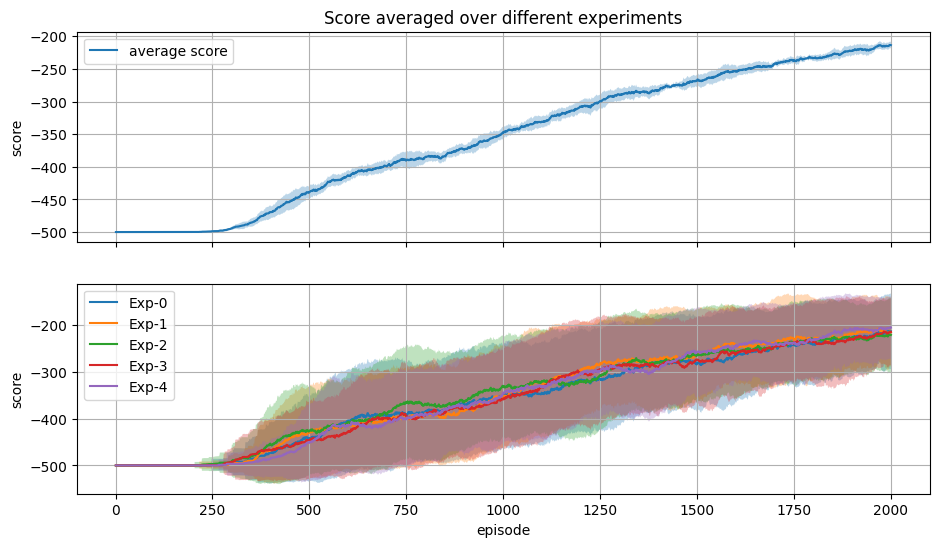

In [25]:
plot_results(avg_scores, std_scores)

The Expected-SARSA algorithm, although it needed a lot of episodes, ended up in a pretty stable learning process. 

## Conclusion

In this notebook, we have implemented the RL algorithm Expected-SARSA (with a neural network). The algorithm is considered a generalization of the Q-Learning algorithm (it differs from it only in its update-rule). In addition, if we use a greedy policy for the expectation in the update rule, we extract back the Q-Learning original update rule.

## References
- [1] Sutton & Barto - Reinforcement Learning An Introduction Second edition (2018)

## Contact
If you have any comments, corrections or questions about the material presented in the notebook, please do not hesitate to email me at elkabetz.roy@gmail.com